In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns
import glob
import pickle
from collections import defaultdict, Counter
import warnings
import Bio.PDB
import gctree

import utils.phenotype_colorscales as pc
from utils.metadata import df_renamed as metadata

In [2]:
out_dir = "output/mutations"

## DMS single AA mutant effects on affinity

In [3]:
# dms_df = pd.read_csv("https://media.githubusercontent.com/media/jbloomlab/Ab-CGGnaive_DMS/main/results/final_variant_scores/final_variant_scores.csv", index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
dms_df = pd.read_csv("https://media.githubusercontent.com/media/jbloomlab/Ab-CGGnaive_DMS/improved-Kd-fitting/tite-seq-modeling/output/final_variant_scores.csv", index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
# remove linker sites
dms_df = dms_df[dms_df.chain != "link"]
# add indicator for wildtype data
dms_df["WT"] = dms_df.wildtype == dms_df.mutant
assert dms_df.position_IMGT.max() < 1000
dms_df["site"] = [f"{chain}-{str(pos).zfill(3)}" for chain, pos in zip(dms_df.chain, dms_df.position_IMGT)]
dms_df

,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind_CGG_old,...,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,bind_CGG,delta_bind_CGG,WT,site
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,FWRH1,A,GAG,True,10.48829,...,19.0,2.0,6.78608,-0.07452,17.0,2.0,8.743409,0.118716,False,H-001
E1(H)C,CGG_naive,E,1,1,H,FWRH1,C,GAG,False,10.44477,...,20.0,2.0,7.44234,0.58174,17.0,2.0,8.608721,-0.015972,False,H-001
E1(H)D,CGG_naive,E,1,1,H,FWRH1,D,GAG,True,10.42771,...,16.0,2.0,6.95940,0.09880,13.0,2.0,8.636242,0.011550,False,H-001
E1(H)E,CGG_naive,E,1,1,H,FWRH1,E,GAG,True,10.45719,...,21170.0,2.0,6.86060,0.00000,18910.0,2.0,NaN,NaN,True,H-001
E1(H)F,CGG_naive,E,1,1,H,FWRH1,F,GAG,False,10.51899,...,24.0,2.0,6.91372,0.05313,21.0,2.0,8.758316,0.133624,False,H-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R128(L)S,CGG_naive,R,235,128,L,FWRL4,S,CGT,True,10.44756,...,39.0,2.0,6.93925,0.07866,33.0,2.0,8.634747,0.010054,False,L-128
R128(L)T,CGG_naive,R,235,128,L,FWRL4,T,CGT,False,10.43023,...,36.0,2.0,6.88956,0.02896,34.0,2.0,8.644639,0.019946,False,L-128
R128(L)V,CGG_naive,R,235,128,L,FWRL4,V,CGT,False,10.38231,...,27.0,2.0,6.78160,-0.07899,24.0,2.0,8.589500,-0.035193,False,L-128


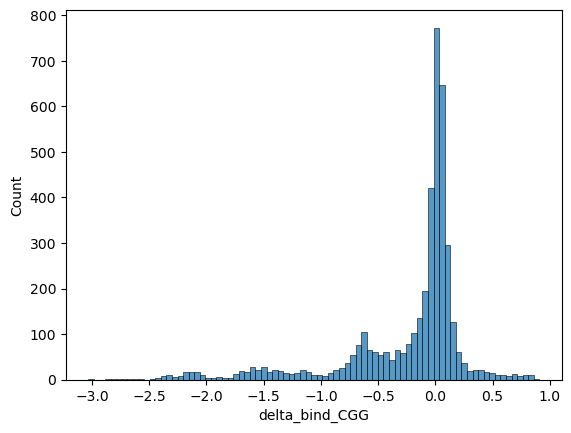

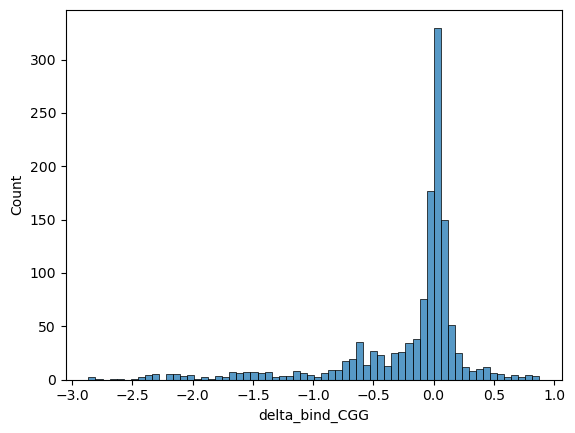

In [4]:
sns.histplot(data=dms_df, x="delta_bind_CGG")
plt.show()

sns.histplot(data=dms_df.loc[dms_df.single_nt], x="delta_bind_CGG")
plt.show()

In [5]:
dms_df.loc[dms_df.single_nt].delta_bind_CGG.describe()

count    1283.000000
mean       -0.203425
std         0.544056
min        -2.864795
25%        -0.265182
50%        -0.004111
75%         0.054141
max         0.877291
Name: delta_bind_CGG, dtype: float64

In [6]:
aa_order = pd.Index(list("RKHDEQNSTYWFAILMVGPC"))
def aa_order_key_fn(aa_index):
    return pd.Index(aa_order.get_loc(aa) for aa in aa_index)

In [7]:
dms_df.delta_bind_CGG.describe()

count    4177.000000
mean       -0.233768
std         0.552152
min        -3.030001
25%        -0.341560
50%        -0.014858
75%         0.050551
max         0.908006
Name: delta_bind_CGG, dtype: float64

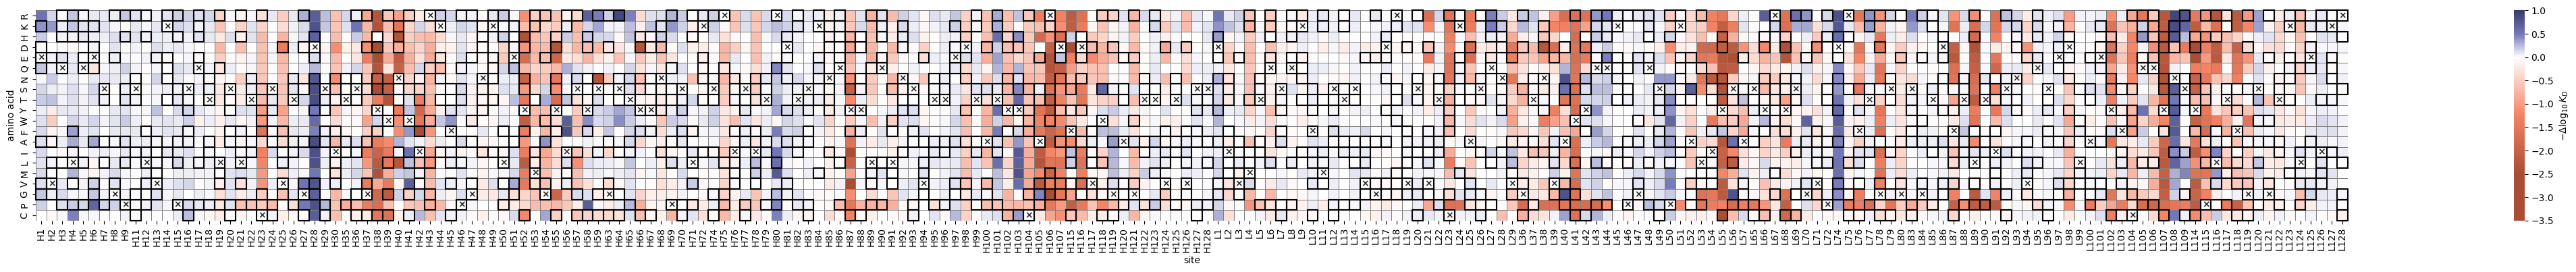

In [8]:
bind_df = dms_df.pivot(index="mutant", columns="site", values="delta_bind_CGG").fillna(0)
accessible_df = dms_df.pivot(index="mutant", columns="site", values="single_nt")
wt_df = dms_df.pivot(index="mutant", columns="site", values="WT")

bind_df.sort_index(key=aa_order_key_fn, axis=0, inplace=True)
accessible_df.sort_index(key=aa_order_key_fn, axis=0, inplace=True)
wt_df.sort_index(key=aa_order_key_fn, axis=0, inplace=True)

annot = pd.DataFrame(np.empty_like(bind_df, dtype=str), index=bind_df.index, columns=bind_df.columns)
annot.iloc[wt_df.values.astype(bool)] = "\u00D7"
# annot.iloc[~accessible_df.values.astype(bool)] = "\u2571"

site_labels_pretty = bind_df.columns.map(lambda x: x.split("-")[0] + str(int(x.split("-")[1])))

plt.figure(figsize=(50, 4))
ax = sns.heatmap(bind_df,
            annot=annot, fmt="", annot_kws=dict(fontweight='bold'),
            cmap=pc.affinity_dms.cmap, norm=pc.affinity_dms.norm,
            cbar_kws=dict(label=r"$-\Delta\log_{10} K_D$"),
            linewidths=0.5, linecolor='grey',
            square=True,
            xticklabels=site_labels_pretty,
)
plt.xlabel("site")
plt.ylabel("amino acid")

ax.collections[0].colorbar.ax.set_yscale('linear')

# Function to draw borders around accessible mutations
def draw_custom_borders(ax, cells):
    for cell in cells:
        i, j = cell
        rect = plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=1.5, clip_on=False)
        ax.add_patch(rect)

# Specify accessible cells to have borders
cells_to_border = []
for i, j in zip(*np.where(accessible_df)):
    cells_to_border.append((i, j))
draw_custom_borders(ax, cells_to_border)

plt.tight_layout()
plt.savefig(f"{out_dir}/heatmap.bind.pdf")
plt.show()

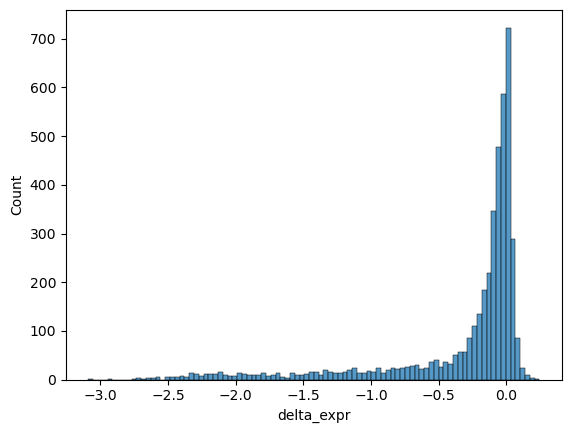

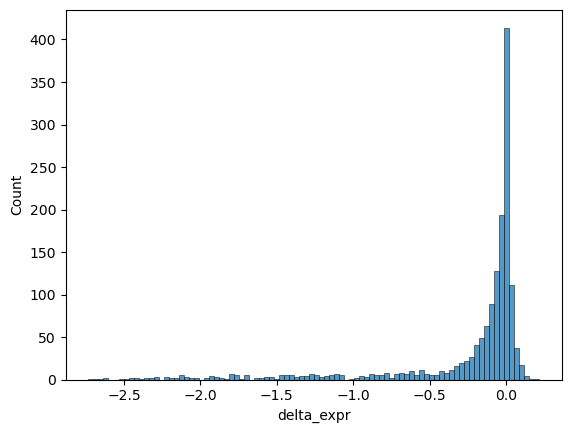

In [9]:
sns.histplot(data=dms_df, x="delta_expr")
plt.show()

sns.histplot(data=dms_df.loc[dms_df.single_nt], x="delta_expr")
plt.show()

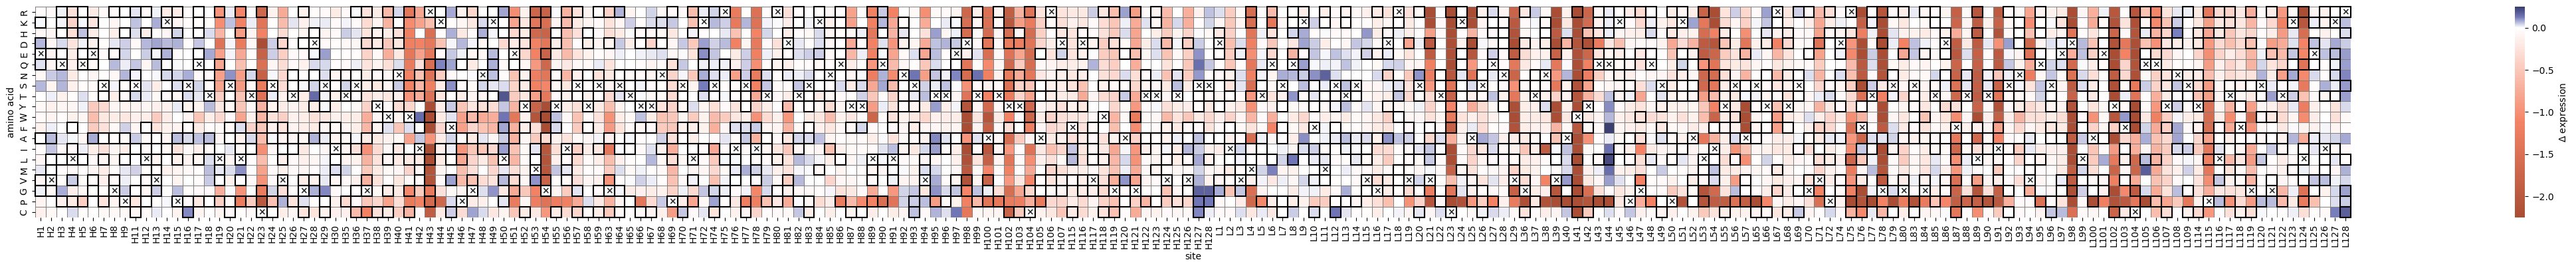

In [10]:
expr_df = dms_df.pivot(index="mutant", columns="site", values="delta_expr").fillna(0)
expr_df.sort_index(key=aa_order_key_fn, axis=0, inplace=True)

vmax = 1
vmin = -1

plt.figure(figsize=(50, 4))
ax = sns.heatmap(expr_df,
                 annot=annot, fmt="", annot_kws=dict(fontweight='bold'),
                 cmap=pc.expression_dms.cmap, norm=pc.expression_dms.norm,
                 cbar_kws=dict(label=r"$\Delta$ expression"),
                 linewidths=0.5, linecolor='grey',
                 square=True,
                 xticklabels=site_labels_pretty,
)

ax.collections[0].colorbar.ax.set_yscale('linear')

draw_custom_borders(ax, cells_to_border)

plt.xlabel("site")
plt.ylabel("amino acid")
plt.tight_layout()
plt.savefig(f"{out_dir}/heatmap.expr.pdf")
plt.show()

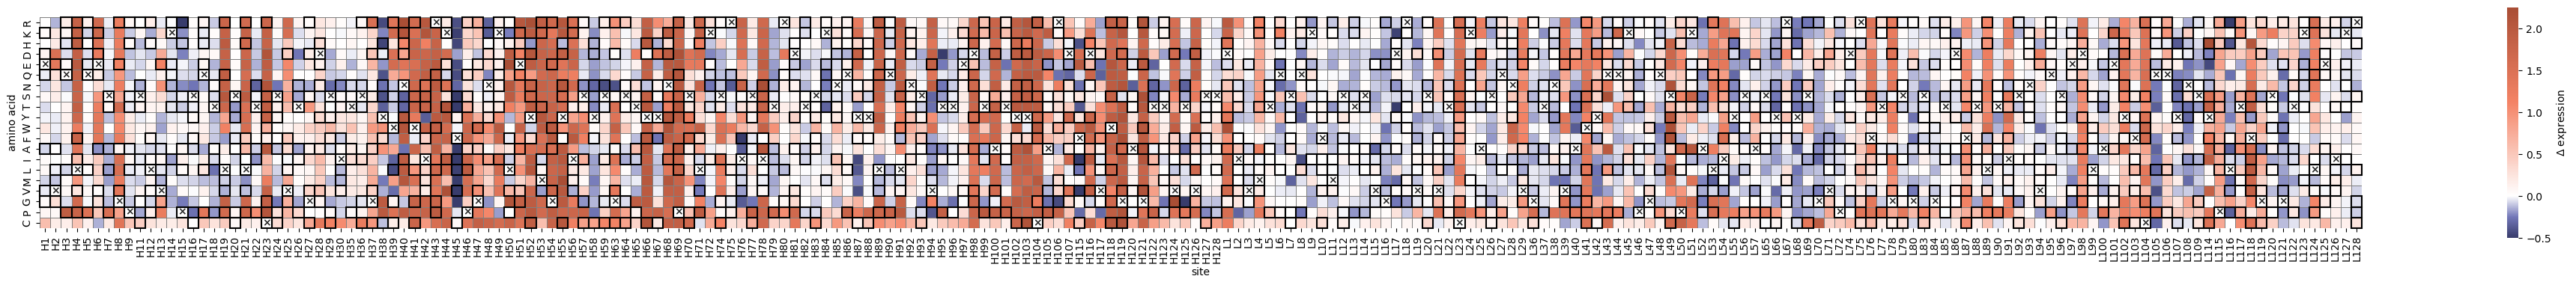

In [11]:
psr_df = dms_df.pivot(index="mutant", columns="site", values="delta_psr").fillna(0)
psr_df.sort_index(key=aa_order_key_fn, axis=0, inplace=True)

plt.figure(figsize=(50, 4))
ax = sns.heatmap(psr_df,
                 annot=annot, fmt="", annot_kws=dict(fontweight='bold'),
                 cmap=pc.psr_dms.cmap, norm=pc.psr_dms.norm,
                 cbar_kws=dict(label=r"$\Delta$ expression"),
                 linewidths=0.5, linecolor='grey',
                 square=True,
                 xticklabels=site_labels_pretty,
)
ax.collections[0].colorbar.ax.set_yscale('linear')
draw_custom_borders(ax, cells_to_border)
plt.xlabel("site")
plt.ylabel("amino acid")
plt.savefig(f"{out_dir}/heatmap.psr.pdf")
plt.show()

## Mutations in GC trees

In [12]:
results = "../nextflow/results"

In [13]:
def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return PR_str[0][2:], PR_str[1], PR_str[3]

files = sorted(glob.glob(f"{results}/gctrees/PR*/gctree.p"), key=gc_key)

trees = {}
for file in files:
    key = "_".join(f"{x}{y}" for x, y in zip(("PR", "mouse", "GC"), gc_key(file)))
    print(key)
    # if key.startswith("mouse7") or key.startswith("mouse8"):
    #     print(f"skipping 10-week {key}")
    #     continue
    assert key not in trees, key
    trees[key] = pickle.load(open(file, "rb"))

    
#     trees = {"_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file))): pickle.load(open(file, "rb"))
#          for file in files}

print(f"loaded {len(trees)} GC trees")

PR1.01_mouse1_GC20
PR1.01_mouse2_GC32
PR1.02_mouse2_GC38
PR1.02_mouse3_GC55
PR1.02_mouse3_GC58
PR1.02_mouse3_GC72
PR1.02_mouse4_GC47
PR1.02_mouse4_GC48
PR1.02_mouse4_GC73
PR1.02_mouse5_GC78
PR1.02_mouse5_GC82
PR1.02_mouse5_GC83
PR1.02_mouse6_GC74
PR1.03_mouse1_GC16
PR1.03_mouse1_GC17
PR1.03_mouse2_GC30
PR1.03_mouse2_GC31
PR1.03_mouse2_GC39
PR1.03_mouse3_GC46
PR1.03_mouse3_GC56
PR1.03_mouse3_GC59
PR1.03_mouse4_GC50
PR1.03_mouse6_GC77
PR1.04_mouse1_GC1
PR1.04_mouse1_GC14
PR1.04_mouse1_GC15
PR1.04_mouse1_GC2
PR1.04_mouse1_GC6
PR1.04_mouse4_GC68
PR1.04_mouse4_GC69
PR1.04_mouse4_GC70
PR1.04_mouse5_GC79
PR1.04_mouse5_GC80
PR1.04_mouse5_GC81
PR1.05_mouse1_GC13
PR1.05_mouse1_GC18
PR1.05_mouse2_GC21
PR1.05_mouse2_GC23
PR1.05_mouse2_GC24
PR1.05_mouse2_GC25
PR1.05_mouse2_GC26
PR1.05_mouse7_GC90
PR1.05_mouse7_GC91
PR1.05_mouse7_GC92
PR1.05_mouse7_GC93
PR1.05_mouse8_GC85
PR1.05_mouse8_GC86
PR1.05_mouse8_GC89
PR1.06_mouse1_GC19
PR1.06_mouse3_GC66
PR1.06_mouse8_GC84
PR1.06_mouse8_GC87
PR1.06_mouse8_G

GC metadata

In [14]:
# metadata.query("(strain == 'wt') & (cell_type == 'GC') & (time != 'w10')", inplace=True)
metadata.to_csv(f"{out_dir}/metadata.renamed.csv")
metadata

,PR,time,strain,mouse,plate,GC,node,cell_type,hc_barcode,lc_barcode,row,col
uid,,,,,,,,,,,,
PR2.01_mouse1_GC1A,2.01,d15,wt,1,2,1,RP,GC,9,9,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
PR2.01_mouse1_GC1C,2.01,d15,wt,1,3,2,RI,GC,2,1,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
PR2.01_mouse1_GC1D,2.01,d15,wt,1,4,3,LI,GC,14,2,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
PR2.01_mouse10_GC10B,2.01,d15,wt,2,1,4,LP,GC,16,10,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
PR2.01_mouse2_GC2A,2.01,d15,wt,3,5,5,RP,GC,10,11,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
...,...,...,...,...,...,...,...,...,...,...,...,...
PR1.05_mouse8_GC86,1.05,w10,wt,29,79,147,RI,LN,14,14,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
PR1.05_mouse8_GC89,1.05,w10,wt,29,82,148,LB,LN,15,15,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
PR1.06_mouse8_GC84,1.06,w10,wt,29,77,149,RP,LN,14,14,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12


In [15]:
pos_df = pd.read_csv("https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
pos_df

,amino_acid,chain,site,KI_codon,annotation
site_scFv,,,,,
1,E,H,1,GAG,FWRH1
2,V,H,2,GTG,FWRH1
3,Q,H,3,CAG,FWRH1
4,L,H,4,CTT,FWRH1
5,Q,H,5,CAG,FWRH1
...,...,...,...,...,...
231,L,L,124,CTA,FWRL4
232,E,L,125,GAA,FWRL4
233,I,L,126,ATA,FWRL4


In [16]:
dms_df

,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind_CGG_old,...,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,bind_CGG,delta_bind_CGG,WT,site
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,FWRH1,A,GAG,True,10.48829,...,19.0,2.0,6.78608,-0.07452,17.0,2.0,8.743409,0.118716,False,H-001
E1(H)C,CGG_naive,E,1,1,H,FWRH1,C,GAG,False,10.44477,...,20.0,2.0,7.44234,0.58174,17.0,2.0,8.608721,-0.015972,False,H-001
E1(H)D,CGG_naive,E,1,1,H,FWRH1,D,GAG,True,10.42771,...,16.0,2.0,6.95940,0.09880,13.0,2.0,8.636242,0.011550,False,H-001
E1(H)E,CGG_naive,E,1,1,H,FWRH1,E,GAG,True,10.45719,...,21170.0,2.0,6.86060,0.00000,18910.0,2.0,NaN,NaN,True,H-001
E1(H)F,CGG_naive,E,1,1,H,FWRH1,F,GAG,False,10.51899,...,24.0,2.0,6.91372,0.05313,21.0,2.0,8.758316,0.133624,False,H-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R128(L)S,CGG_naive,R,235,128,L,FWRL4,S,CGT,True,10.44756,...,39.0,2.0,6.93925,0.07866,33.0,2.0,8.634747,0.010054,False,L-128
R128(L)T,CGG_naive,R,235,128,L,FWRL4,T,CGT,False,10.43023,...,36.0,2.0,6.88956,0.02896,34.0,2.0,8.644639,0.019946,False,L-128
R128(L)V,CGG_naive,R,235,128,L,FWRL4,V,CGT,False,10.38231,...,27.0,2.0,6.78160,-0.07899,24.0,2.0,8.589500,-0.035193,False,L-128


In [17]:
igh_pos_map = pos_df.loc[pos_df.chain == "H", "site"].reset_index(drop=True)
igk_pos_map = pos_df.loc[pos_df.chain == "L", "site"].reset_index(drop=True)

## Mutation events

In [18]:
hits_df = pd.DataFrame(np.zeros_like(bind_df.values), index=bind_df.index, columns=bind_df.columns)

dms_df["mutation events (15-day)"] = 0
dms_df["mutation events (20-day)"] = 0
dms_df["mutation events (10-week)"] = 0
dms_df["mutation events (LMP2A)"] = 0

for gc, tree in trees.items():
    if gc not in metadata.index:
        print(f"WARNING: {gc} not found in metadata")
        continue
    if (metadata.strain[gc] == "wt") and (metadata.time[gc] == "d15"):
        suffix = "15-day"
    elif (metadata.strain[gc] == "wt") and (metadata.time[gc] == "d20"):
        suffix = "20-day"
    elif (metadata.strain[gc] == "wt") and (metadata.time[gc] == "w10"):
        suffix = "10-week"
    elif (metadata.strain[gc] == "LMP2A"):
        suffix = "LMP2A"
    else:
        raise ValueError(f"unknown gc {gc}")
    for node in tree.tree.iter_descendants(strategy="preorder"):
        for mutation in set(node.mutations) - set(node.up.mutations):
            mutant = mutation[-1]
            if mutant != "*":
                site = dms_df.site[mutation]
                hits_df.loc[mutant, site] += 1
                dms_df.loc[mutation, f"mutation events ({suffix})"] += 1

# NOTE: "total" mutation events means day 15 and day 20
dms_df["mutation events"] = dms_df["mutation events (15-day)"] + dms_df["mutation events (20-day)"]

hits_df

site,H-001,H-002,H-003,H-004,H-005,H-006,H-007,H-008,H-009,H-011,...,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128
mutant,,,,,,,,,,,,,,,,,,,,,
R,0.0,0.0,13.0,0.0,4.0,0.0,0.0,2.0,1.0,8.0,...,0.0,0.0,1.0,0.0,30.0,0.0,0.0,18.0,62.0,0.0
K,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,19.0,27.0,0.0,0.0
H,0.0,0.0,10.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0
D,17.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,5.0,0.0,0.0,0.0,4.0,0.0,39.0,0.0,0.0,0.0
E,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,9.0,0.0,51.0,0.0,0.0,0.0,40.0,0.0
Q,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,52.0,5.0,33.0,0.0,28.0,0.0
N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,...,0.0,0.0,0.0,0.0,132.0,0.0,1.0,1.0,25.0,0.0
S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,12.0,1.0,2.0,0.0,0.0,3.0,0.0
T,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,...,0.0,2.0,0.0,0.0,21.0,0.0,0.0,24.0,14.0,0.0


In [19]:
dms_df.loc["A105(H)G"]

target                       CGG_naive
wildtype                             A
position                            96
position_IMGT                      105
chain                                H
annotation                       CDRH3
mutant                               G
codon                              GCA
single_nt                         True
bind_CGG_old                  10.78819
n_bc_bind_CGG                     15.0
n_libs_bind_CGG                    2.0
bind_TuGG                      6.25772
delta_bind_TuGG               -0.08157
n_bc_bind_TuGG                    17.0
n_libs_bind_TuGG                   2.0
expr                          10.44506
delta_expr                    -0.00561
n_bc_expr                         18.0
n_libs_expr                        2.0
psr                            6.58706
delta_psr                     -0.27353
n_bc_psr                          15.0
n_libs_psr                         2.0
bind_CGG                      9.070766
delta_bind_CGG           

In [20]:
hits_df.max().max()

487.0

## Comparing mutation incidence across mouse types

accessible mutations observed in 20-day mice: 894
accessible mutations not observed in 20-day mice: 611
inaccessible mutations observed in 20-day mice: 135
inaccessible mutations not observed in 20-day mice: 2760
accessible mutations observed in 10-week mice: 487
accessible mutations not observed in 10-week mice: 1018
inaccessible mutations observed in 10-week mice: 70
inaccessible mutations not observed in 10-week mice: 2825


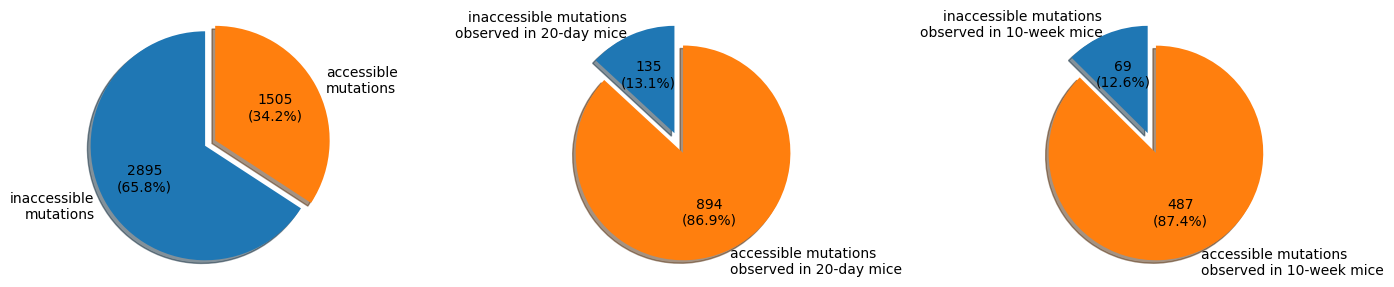

In [21]:
print(f"accessible mutations observed in 20-day mice: {len(dms_df.loc[dms_df.single_nt & (dms_df['mutation events (20-day)'] > 0)])}")
print(f"accessible mutations not observed in 20-day mice: {len(dms_df.loc[dms_df.single_nt & (dms_df['mutation events (20-day)'] == 0)])}")
print(f"inaccessible mutations observed in 20-day mice: {len(dms_df.loc[~dms_df.single_nt & (dms_df['mutation events (20-day)'] > 0)])}")
print(f"inaccessible mutations not observed in 20-day mice: {len(dms_df.loc[~dms_df.single_nt & (dms_df['mutation events (20-day)'] == 0)])}")

print(f"accessible mutations observed in 10-week mice: {len(dms_df.loc[dms_df.single_nt & (dms_df['mutation events (10-week)'] > 0)])}")
print(f"accessible mutations not observed in 10-week mice: {len(dms_df.loc[dms_df.single_nt & (dms_df['mutation events (10-week)'] == 0)])}")
print(f"inaccessible mutations observed in 10-week mice: {len(dms_df.loc[~dms_df.single_nt & (dms_df['mutation events (10-week)'] > 0)])}")
print(f"inaccessible mutations not observed in 10-week mice: {len(dms_df.loc[~dms_df.single_nt & (dms_df['mutation events (10-week)'] == 0)])}")

def func(pct, data):
    absolute = int(pct / 100 * np.sum(data))
    return f"{absolute:d}\n({pct:.1f}%)"

plt.figure(figsize=(14, 3))

plt.subplot(131)
data = [len(dms_df) - sum(dms_df.single_nt), sum(dms_df.single_nt)]
plt.pie(data,
        labels=("inaccessible\nmutations", "accessible\nmutations"),
        explode=(0, 0.1), autopct=lambda pct: func(pct, data),
        shadow=True, startangle=90)
plt.axis('equal')

plt.subplot(132)
data = [len(dms_df.loc[~dms_df.single_nt & (dms_df['mutation events (20-day)'] > 0)]), len(dms_df.loc[dms_df.single_nt & (dms_df['mutation events (20-day)'] > 0)])]
plt.pie(data,
        labels=("inaccessible mutations\nobserved in 20-day mice", "accessible mutations\nobserved in 20-day mice"),
        explode=(0, 0.2), autopct=lambda pct: func(pct, data),
        shadow=True, startangle=90)
plt.axis('equal')

plt.subplot(133)
data = [len(dms_df.loc[~dms_df.single_nt & (dms_df['mutation events (10-week)'] > 0)]), len(dms_df.loc[dms_df.single_nt & (dms_df['mutation events (10-week)'] > 0)])]
plt.pie(data,
        labels=("inaccessible mutations\nobserved in 10-week mice", "accessible mutations\nobserved in 10-week mice"),
        explode=(0, 0.2), autopct=lambda pct: func(pct, data),
        shadow=True, startangle=90)
plt.axis('equal')

plt.tight_layout()
plt.savefig(f"{out_dir}/piechart.pdf")
plt.show()

# sns.boxplot(data=dms_df, x="single_nt", y="mutation events (20-day)")
# plt.show()

# sns.stripplot(data=dms_df, x="single_nt", y="mutation events (10-week)")
# plt.show()

In [22]:
dms_df[["single_nt", "mutation events (20-day)"]]

,single_nt,mutation events (20-day)
mutation,,
E1(H)A,True,4
E1(H)C,False,0
E1(H)D,True,7
E1(H)E,True,0
E1(H)F,False,0
...,...,...
R128(L)S,True,0
R128(L)T,False,0
R128(L)V,False,0


/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key

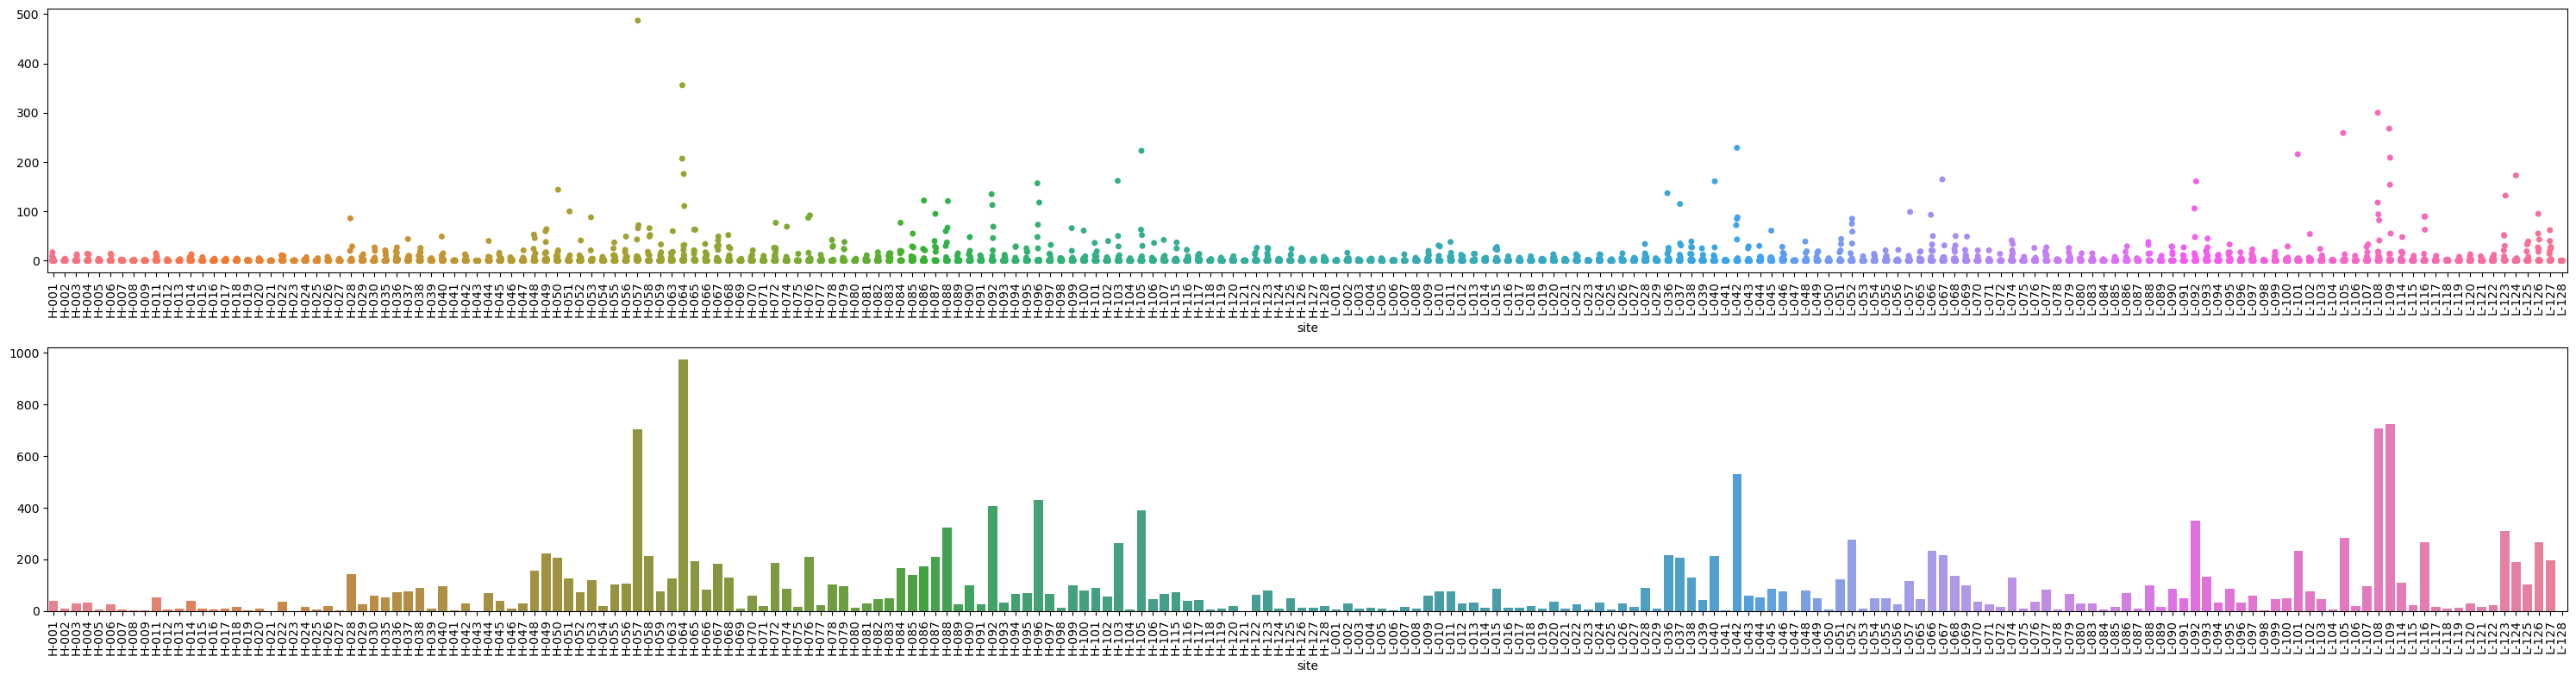

In [23]:
plt.figure(figsize=(30, 8))

plt.subplot(211)
g = sns.stripplot(data=hits_df)
for item in g.get_xticklabels():
    item.set_rotation(90)

plt.subplot(212, sharex=g)
g = sns.barplot(data=hits_df, errorbar=None, estimator=sum)
for item in g.get_xticklabels():
    item.set_rotation(90)

plt.tight_layout()
plt.show()

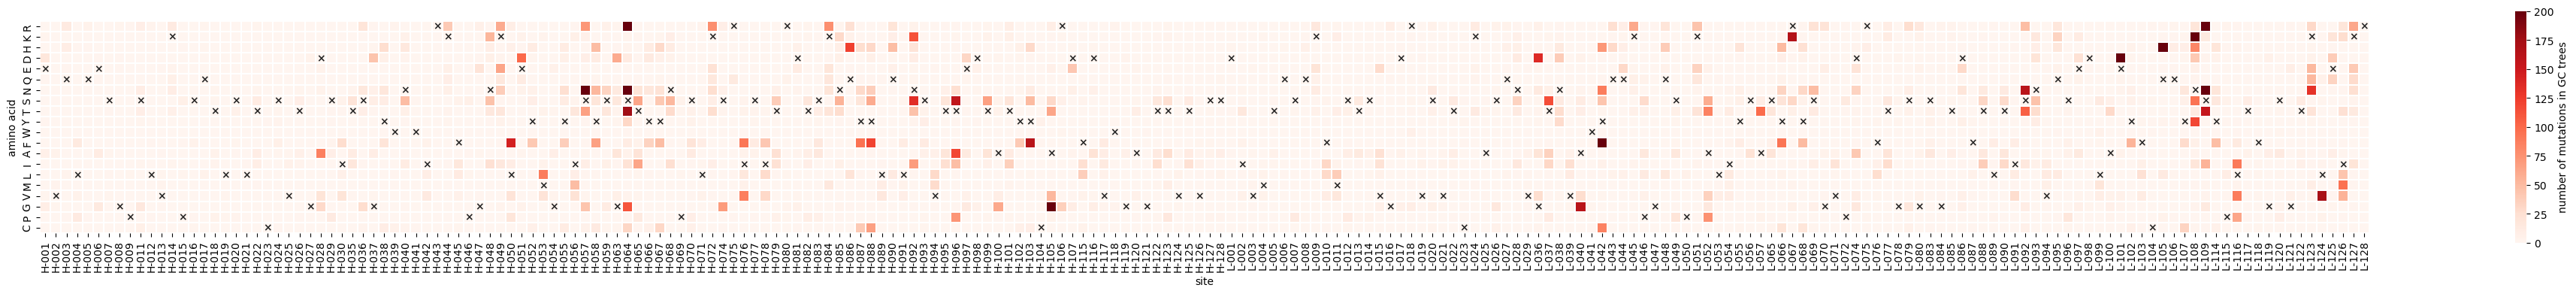

In [24]:
plt.figure(figsize=(50, 4))
sns.heatmap(hits_df, annot=annot, fmt="", annot_kws=dict(fontweight="bold"),
            cmap="Reds",
#             vmin=100,
            vmax=200,
            cbar_kws=dict(label="number of mutations in GC trees"), linewidths=.1, square=True)
plt.xlabel("site")
plt.ylabel("amino acid")
plt.show()

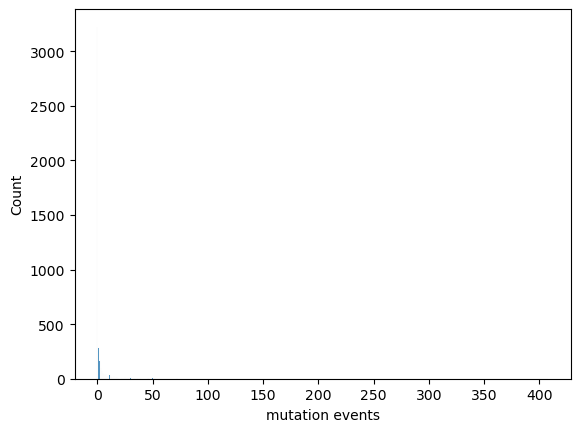

mutation
S57(H)N     408
S64(H)N     288
N108(L)K    248
S109(L)N    210
Q105(L)H    205
A105(H)G    182
E101(L)D    181
S109(L)R    177
Y42(L)F     170
S64(H)R     168
L124(L)V    144
S64(H)T     141
R67(L)K     136
T96(H)S     135
A40(L)G     133
Y103(H)F    126
S92(L)N     126
G36(L)D     120
S109(L)T    119
L50(H)F     113
Name: mutation events, dtype: int64

In [25]:
sns.histplot(data=dms_df, x="mutation events")
plt.show()

dms_df["mutation events"].sort_values(ascending=False)[:20]

## Add mutability to `dms_df`

In [26]:
from Bio.codonalign.codonseq import CodonSeq


chigy_hc_passenger = pd.read_csv("../passenger/output/chigy_hc_mutation_rates_nt.csv", index_col=0)
chigy_lc_passenger = pd.read_csv("../passenger/output/chigy_lc_mutation_rates_nt.csv", index_col=0)

pd.concat([chigy_hc_passenger.tail(1), chigy_lc_passenger.head(1)])
mutation_rates_nt_passenger = pd.concat([chigy_hc_passenger.head(-1), chigy_lc_passenger.head(-1)])
# Assert that we've glued things together covering all sites
assert (mutation_rates_nt_passenger.index == np.arange(len(mutation_rates_nt_passenger))).all()

mutation_rates_nt = mutation_rates_nt_passenger


# mutability = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_mutability.csv", sep=" ", index_col=0).squeeze("columns")
# substitution = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_substitution.csv", sep=" ", index_col=0)

naive = next(iter(trees.values())).tree.sequence
igk_idx = 336

# padded_igh = "NN" + naive[:igk_idx] + "NN"
# padded_igk = "NN" + naive[igk_idx:] + "NN"
# # mutabilities of each nucleotide
# contexts = [padded_igh[(i - 2) : (i + 3)]
#                 for i in range(2, len(padded_igh) - 2)
#                ] + [padded_igk[(i - 2) : (i + 3)]
#                     for i in range(2, len(padded_igk) - 2)
#                    ]

# # mutation rates at each site in naive
# mutation_rates_nt = pd.concat((mutability[context] * substitution.loc[context] for context in contexts), axis=1).T.reset_index()

# now we want the above at the codon level

codons = CodonSeq(naive)

# assert len(contexts) == len(naive) == len(codons)

dms_df["mutation rate"] = 0.0

for codon_idx in range(codons.get_codon_num()):
    codon = CodonSeq(codons.get_codon(codon_idx))
    aa = codon.translate()
    for codon_pos in range(3):
        idx = 3 * codon_idx + codon_pos
        if idx < igk_idx:
            chain = "H"
            imgt_idx = igh_pos_map[idx // 3]
        else:
            chain = "L"
            imgt_idx = igk_pos_map[(idx - igk_idx) // 3]
        assert naive[idx] == codon[codon_pos]
        for alt_nt in "ACGT":
            if alt_nt != naive[idx]:
                mutated_codon = list(codon)
                mutated_codon[codon_pos] = alt_nt
                mutated_codon = CodonSeq("".join(mutated_codon))
                mutated_aa = mutated_codon.translate()
                if mutated_aa != "*" and mutated_aa != aa:
                    mutation = f"{aa}{imgt_idx}({chain}){mutated_aa}"
                    dms_df.loc[mutation, "mutation rate"] += mutation_rates_nt.loc[idx, alt_nt]
dms_df

/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/Bio/codonalign/__init__.py:23: BiopythonExperimentalWarning: Bio.codonalign is an experimental module which may undergo significant changes prior to its future official release.
  warnings.warn(


,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind_CGG_old,...,bind_CGG,delta_bind_CGG,WT,site,mutation events (15-day),mutation events (20-day),mutation events (10-week),mutation events (LMP2A),mutation events,mutation rate
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,FWRH1,A,GAG,True,10.48829,...,8.743409,0.118716,False,H-001,2,4,0,0,6,0.000409
E1(H)C,CGG_naive,E,1,1,H,FWRH1,C,GAG,False,10.44477,...,8.608721,-0.015972,False,H-001,0,0,0,0,0,0.000000
E1(H)D,CGG_naive,E,1,1,H,FWRH1,D,GAG,True,10.42771,...,8.636242,0.011550,False,H-001,3,7,5,2,10,0.000803
E1(H)E,CGG_naive,E,1,1,H,FWRH1,E,GAG,True,10.45719,...,NaN,NaN,True,H-001,0,0,0,0,0,0.000000
E1(H)F,CGG_naive,E,1,1,H,FWRH1,F,GAG,False,10.51899,...,8.758316,0.133624,False,H-001,0,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R128(L)S,CGG_naive,R,235,128,L,FWRL4,S,CGT,True,10.44756,...,8.634747,0.010054,False,L-128,0,0,0,0,0,0.000000
R128(L)T,CGG_naive,R,235,128,L,FWRL4,T,CGT,False,10.43023,...,8.644639,0.019946,False,L-128,0,0,0,0,0,0.000000
R128(L)V,CGG_naive,R,235,128,L,FWRL4,V,CGT,False,10.38231,...,8.589500,-0.035193,False,L-128,0,0,0,0,0,0.000000


In [27]:
assert (~dms_df.single_nt & (dms_df["mutation rate"] > 0)).sum() == 0

<Axes: xlabel='delta_bind_CGG', ylabel='Density'>

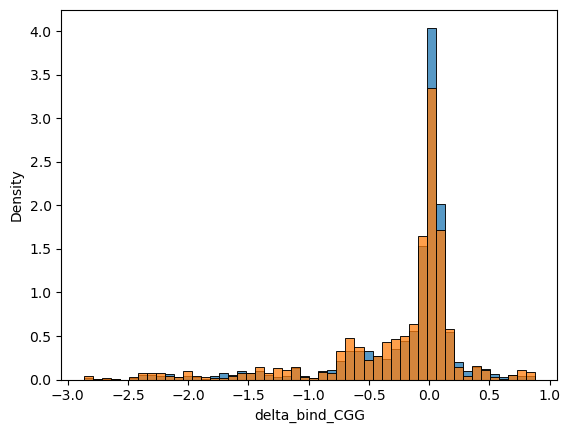

In [28]:
sns.histplot(data=dms_df.query("single_nt == True"), x="delta_bind_CGG", bins=50, stat="density")
sns.histplot(data=dms_df.query("single_nt == True"), x="delta_bind_CGG", weights="mutation rate", bins=50, stat="density")

In [29]:
dms_df.loc[(dms_df["mutation events"]>100)].sort_values("mutation events")[["delta_bind_CGG", "wildtype", "mutant", "mutation events", "mutation rate"]]

,delta_bind_CGG,wildtype,mutant,mutation events,mutation rate
mutation,,,,,
Q86(H)H,-0.001992,Q,H,102,0.004252
Y88(H)F,0.052247,Y,F,104,0.005602
N92(H)S,-0.091754,N,S,106,0.006735
N108(L)Y,0.731962,N,Y,107,0.004239
K123(L)N,-0.048918,K,N,108,0.008952
L50(H)F,-0.006194,L,F,113,0.004258
S109(L)T,0.016776,S,T,119,0.007625
G36(L)D,-0.599536,G,D,120,0.010273
S92(L)N,0.035227,S,N,126,0.006260


In [30]:
dms_df.loc["N108(L)E"]

target                       CGG_naive
wildtype                             N
position                           219
position_IMGT                      108
chain                                L
annotation                       CDRL3
mutant                               E
codon                              AAC
single_nt                        False
bind_CGG_old                   9.54056
n_bc_bind_CGG                     37.0
n_libs_bind_CGG                    2.0
bind_TuGG                      6.11732
delta_bind_TuGG               -0.22197
n_bc_bind_TuGG                    40.0
n_libs_bind_TuGG                   2.0
expr                          10.36579
delta_expr                    -0.08488
n_bc_expr                         41.0
n_libs_expr                        2.0
psr                            6.60032
delta_psr                     -0.26028
n_bc_psr                          40.0
n_libs_psr                         2.0
bind_CGG                      7.902278
delta_bind_CGG           

In [31]:
pos_df.loc[90:100]

,amino_acid,chain,site,KI_codon,annotation
site_scFv,,,,,
90,T,H,99,ACA,FWRH3
91,A,H,100,GCC,FWRH3
92,T,H,101,ACA,FWRH3
93,Y,H,102,TAT,FWRH3
94,Y,H,103,TAC,FWRH3
95,C,H,104,TGT,FWRH3
96,A,H,105,GCA,CDRH3
97,R,H,106,AGG,CDRH3
98,D,H,107,GAC,CDRH3


In [32]:
# most_mutated_df = dms_df.loc[(dms_df["mutation events"]>100)].sort_values("mutation events")[["delta_bind_CGG", "wildtype", "mutant", "mutation events", "mutation rate", "mutation rate RS5NF"]]

In [33]:
# plt.figure(figsize=(10, 8))  # Set the size of the plot

# # Create scatter plot
# plt.scatter(most_mutated_df['mutation rate'], most_mutated_df['mutation rate RS5NF'], alpha=0.6)

# # Label each point
# for i in range(len(most_mutated_df)):
#     plt.text(most_mutated_df['mutation rate'][i], most_mutated_df['mutation rate RS5NF'][i], most_mutated_df.index[i], fontsize=8)

# # Set labels and title
# plt.xlabel('Mutation Rate')
# plt.ylabel('Mutation Rate RS5NF')
# plt.title('Mutation Rate vs Mutation Rate RS5NF')

# plt.show()

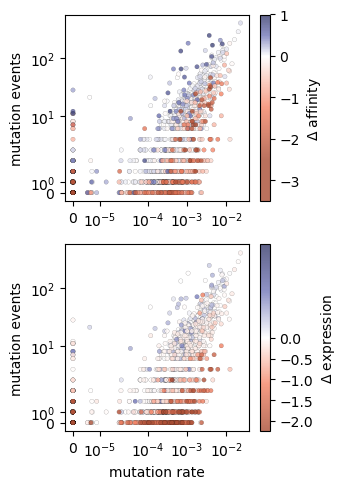

In [34]:
plt.figure(figsize=(3.5, 5))

ax = plt.subplot(211)
plt.scatter(data=dms_df.sort_values(by="delta_bind_CGG", key=lambda val: np.abs(val)), x="mutation rate", y="mutation events", c="delta_bind_CGG", s=10, alpha=0.8,
            cmap=pc.affinity_dms.cmap, norm=pc.affinity_dms.norm,
            clip_on=False, edgecolors="k", linewidths=0.1)
# plt.xlabel("mutation rate")
plt.ylabel("mutation events")
linthresh_x = 3 * dms_df.loc[dms_df["mutation rate"] > 0, "mutation rate"].min()
linthresh_y = 6
plt.xscale("symlog", linthresh=linthresh_x)
plt.yscale("symlog", linthresh=linthresh_y)
plt.colorbar(label=r"$\Delta$ affinity")

plt.subplot(212, sharex=ax)
plt.scatter(data=dms_df.sort_values(by="delta_expr", key=lambda val: np.abs(val)), x="mutation rate", y="mutation events", c="delta_expr", s=10, alpha=0.8,
            cmap=pc.expression_dms.cmap, norm=pc.expression_dms.norm,
            clip_on=False, edgecolors="k", linewidths=0.1)
plt.xlabel("mutation rate")
plt.ylabel("mutation events")
plt.xscale("symlog", linthresh=linthresh_x)
plt.yscale("symlog", linthresh=linthresh_y)
plt.colorbar(label=r"$\Delta$ expression")

plt.tight_layout()
plt.savefig(f"{out_dir}/eventsVsrate.pdf")
plt.show()

Event / rate Vs affinity (getting at selection sensitivity)

In [35]:
gain_thresh = 0.3
loss_thresh = -1
dms_df.loc[~dms_df.delta_bind_CGG.isna(), "affinity change stratum"] = "affinity neutral"
dms_df.loc[dms_df.delta_bind_CGG > gain_thresh, "affinity change stratum"] = "affinity gain"
dms_df.loc[dms_df.delta_bind_CGG < loss_thresh, "affinity change stratum"] = "affinity loss"

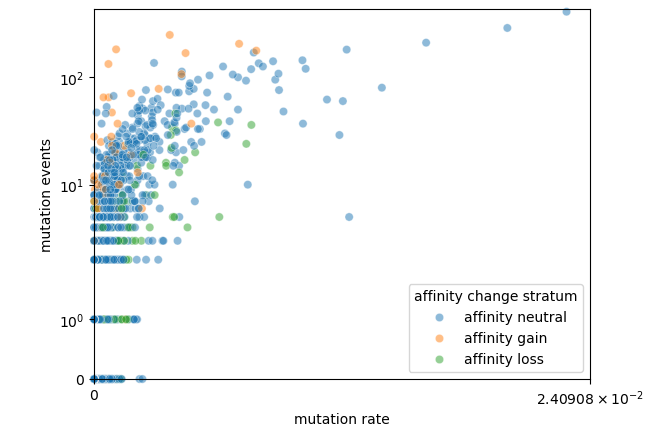

In [36]:
sns.scatterplot(data=dms_df, hue="affinity change stratum", y="mutation events", x="mutation rate", alpha=0.5, clip_on=False)
plt.xscale("symlog")
plt.yscale("symlog")
plt.xlim(0, None)
plt.ylim(0, None)
plt.show()

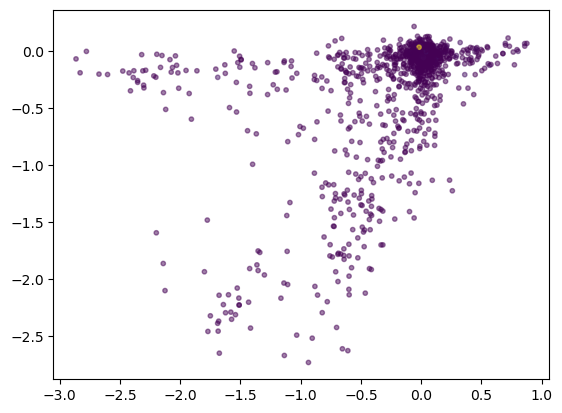

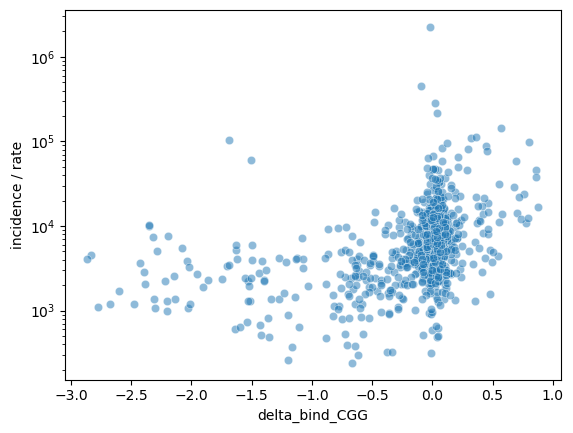

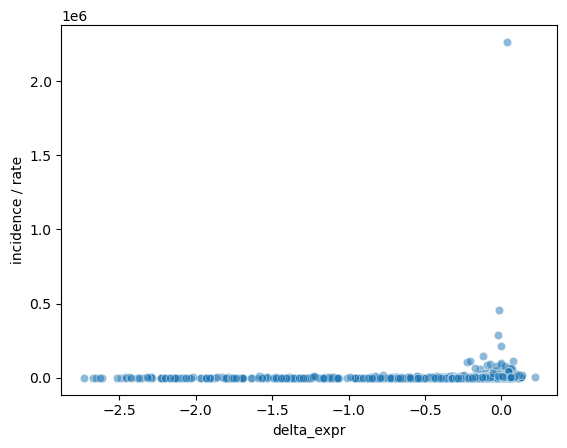

/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


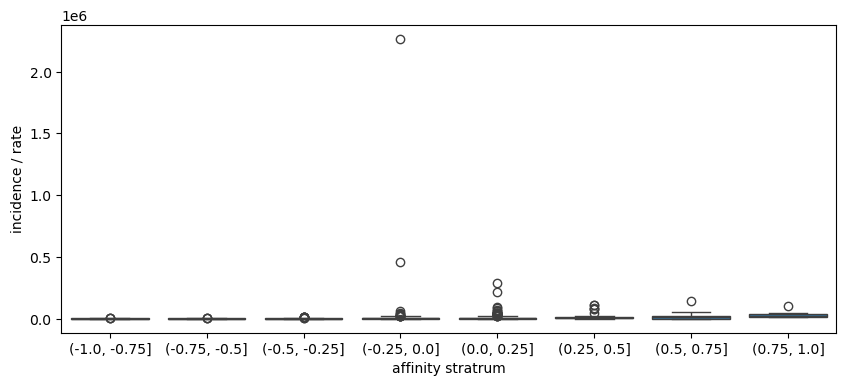

/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


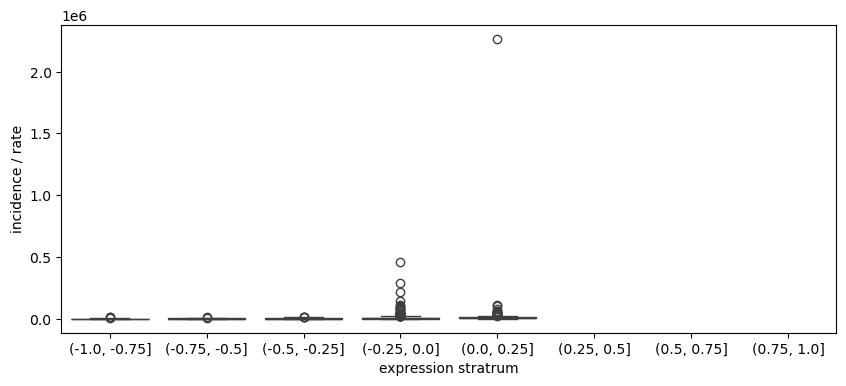

/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


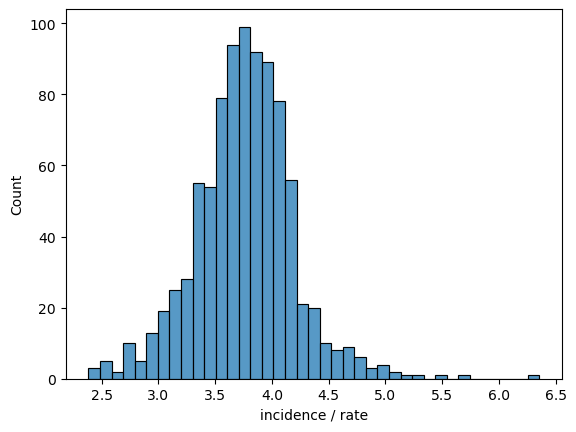

In [37]:
affinity_incidence_rate_df = dms_df[["delta_bind_CGG", "delta_expr", "mutation events (20-day)", "mutation rate"]].copy()
affinity_incidence_rate_df["incidence / rate"] = affinity_incidence_rate_df["mutation events (20-day)"] / affinity_incidence_rate_df["mutation rate"]

bins = np.linspace(-1, 1, 9)
affinity_incidence_rate_df["affinity stratrum"] = pd.cut(affinity_incidence_rate_df["delta_bind_CGG"], bins=bins)
affinity_incidence_rate_df["expression stratrum"] = pd.cut(affinity_incidence_rate_df["delta_expr"], bins=bins)

plt.scatter(affinity_incidence_rate_df.delta_bind_CGG, affinity_incidence_rate_df.delta_expr, c=affinity_incidence_rate_df["incidence / rate"], alpha=0.5, s=10)
plt.show()

sns.scatterplot(data=affinity_incidence_rate_df, x="delta_bind_CGG", y="incidence / rate", alpha=0.5)
plt.yscale("log")
plt.show()
sns.scatterplot(data=affinity_incidence_rate_df, x="delta_expr", y="incidence / rate", alpha=0.5)
plt.show()

plt.figure(figsize=(10, 4))
sns.boxplot(data=affinity_incidence_rate_df, x="affinity stratrum", y="incidence / rate")
plt.show()
plt.figure(figsize=(10, 4))
sns.boxplot(data=affinity_incidence_rate_df, x="expression stratrum", y="incidence / rate")
plt.show()

sns.histplot(x=np.log10(affinity_incidence_rate_df["incidence / rate"]))
plt.show()

In [38]:
affinity_incidence_rate_df

,delta_bind_CGG,delta_expr,mutation events (20-day),mutation rate,incidence / rate,affinity stratrum,expression stratrum
mutation,,,,,,,
E1(H)A,0.118716,-0.00453,4,0.000409,9779.227998,"(0.0, 0.25]","(-0.25, 0.0]"
E1(H)C,-0.015972,-0.12703,0,0.000000,NaN,"(-0.25, 0.0]","(-0.25, 0.0]"
E1(H)D,0.011550,0.06551,7,0.000803,8713.689851,"(0.0, 0.25]","(0.0, 0.25]"
E1(H)E,NaN,0.00000,0,0.000000,NaN,NaN,"(-0.25, 0.0]"
E1(H)F,0.133624,-0.11904,0,0.000000,NaN,"(0.0, 0.25]","(-0.25, 0.0]"
...,...,...,...,...,...,...,...
R128(L)S,0.010054,0.09246,0,0.000000,NaN,"(0.0, 0.25]","(0.0, 0.25]"
R128(L)T,0.019946,0.08793,0,0.000000,NaN,"(0.0, 0.25]","(0.0, 0.25]"
R128(L)V,-0.035193,0.03640,0,0.000000,NaN,"(-0.25, 0.0]","(0.0, 0.25]"


/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


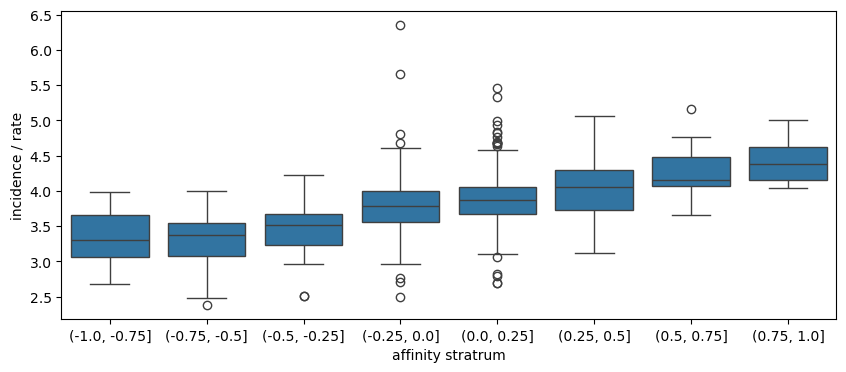

/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


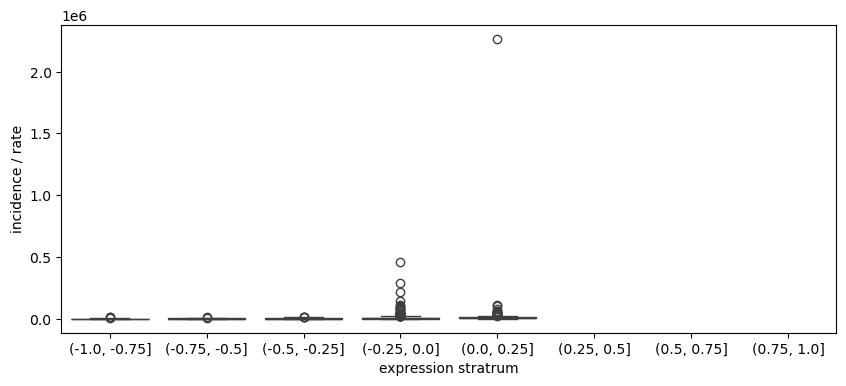

In [39]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=affinity_incidence_rate_df["affinity stratrum"], y=np.log10(affinity_incidence_rate_df["incidence / rate"]))
plt.show()
plt.figure(figsize=(10, 4))
sns.boxplot(data=affinity_incidence_rate_df, x="expression stratrum", y="incidence / rate")
plt.show()

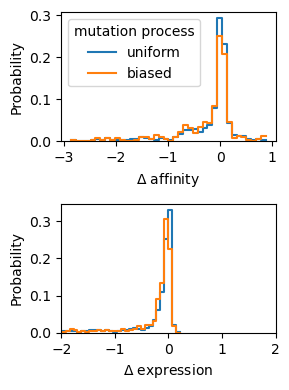

In [40]:
plt.figure(figsize=(3, 4))

ax = plt.subplot(211)
sns.histplot(data=dms_df.loc[dms_df.single_nt], x="delta_bind_CGG", bins=40, stat="probability", element="step", fill=False, label="uniform")
sns.histplot(data=dms_df.loc[dms_df.single_nt], x="delta_bind_CGG", bins=40, weights=dms_df.loc[dms_df.single_nt, "mutation rate"], stat="probability", element="step", fill=False, label="biased")
# plt.xlim(-2, 2)
plt.xlabel(r"$\Delta$ affinity")
# plt.yscale("log")
plt.legend(title="mutation process", fontsize=10)

plt.subplot(212)
sns.histplot(data=dms_df.loc[dms_df.single_nt], x="delta_expr", bins=40, stat="probability", element="step", fill=False, label="uniform")
sns.histplot(data=dms_df.loc[dms_df.single_nt], x="delta_expr", bins=40, weights=dms_df.loc[dms_df.single_nt, "mutation rate"], stat="probability", element="step", fill=False, label="biased")
plt.xlim(-2, 2)
plt.xlabel(r"$\Delta$ expression")
# plt.yscale("log")


# sns.jointplot(data=dms_df.loc[dms_df.single_nt], x="delta_bind_CGG", y="delta_expr")


plt.tight_layout()
plt.savefig(f"{out_dir}/mutation-bias.pdf")
plt.show()

/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key

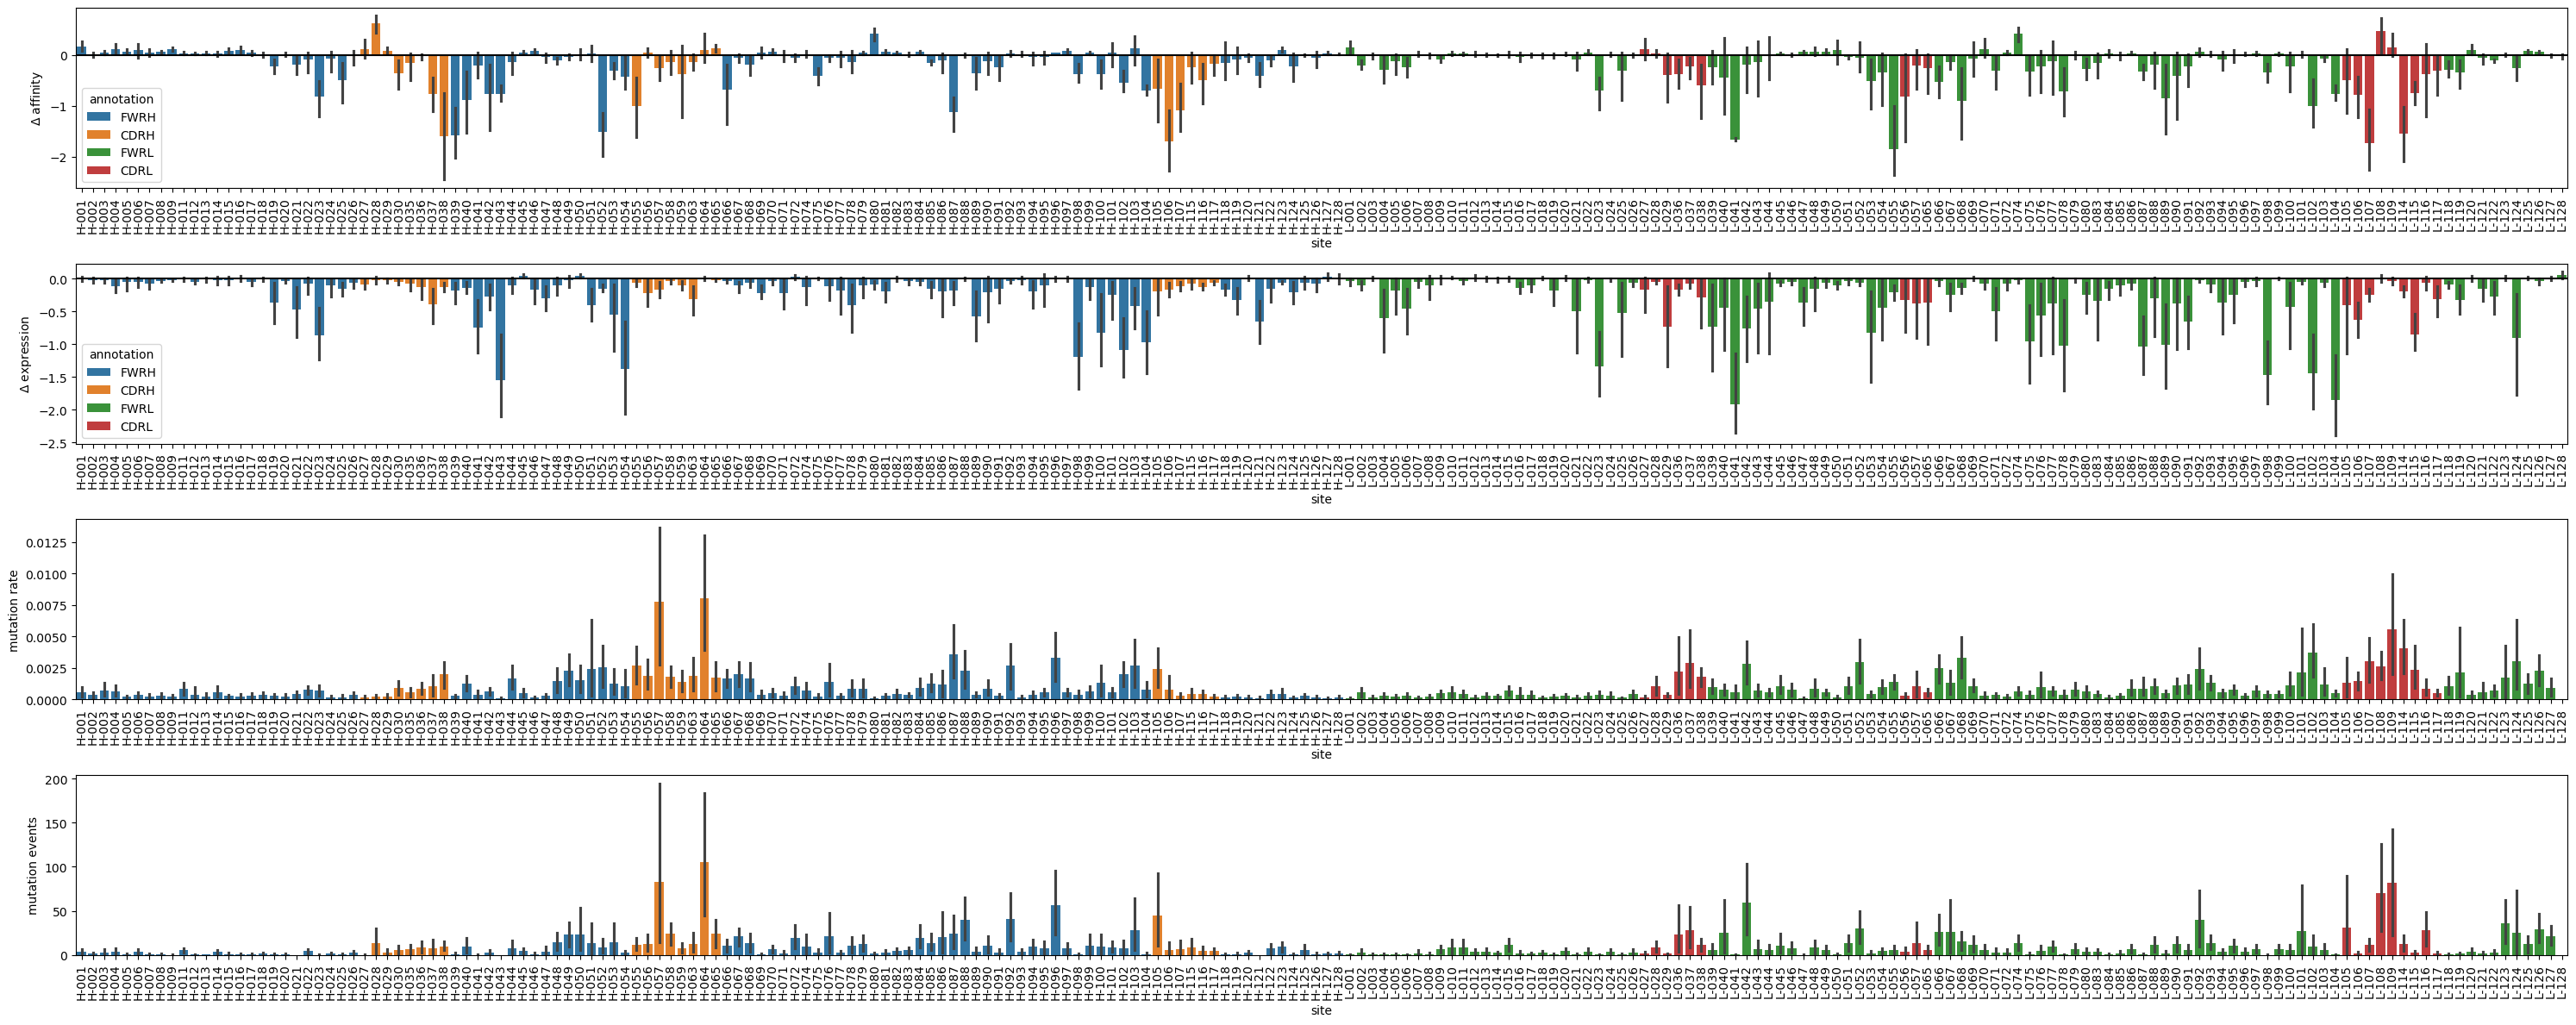

In [41]:
plt.figure(figsize=(30, 12))
plt.subplot(411)
sns.barplot(data=dms_df.loc[dms_df.single_nt], x="site", y="delta_bind_CGG",
            hue=dms_df.loc[dms_df.single_nt].annotation.str[:-1],
            order=sorted(dms_df.site.unique()), dodge=False)
plt.axhline(0, c="k")
plt.ylabel(r"$\Delta$ affinity")
plt.xticks(rotation=90)

plt.subplot(412)
sns.barplot(data=dms_df.loc[dms_df.single_nt], x="site", y="delta_expr",
            hue=dms_df.loc[dms_df.single_nt].annotation.str[:-1],
            order=sorted(dms_df.site.unique()), dodge=False)
plt.axhline(0, c="k")
plt.ylabel(r"$\Delta$ expression")
plt.xticks(rotation=90)

plt.subplot(413)
g = sns.barplot(data=dms_df.loc[dms_df.single_nt], x="site", y="mutation rate",
            hue=dms_df.loc[dms_df.single_nt].annotation.str[:-1],
            order=sorted(dms_df.site.unique()), dodge=False)
plt.xticks(rotation=90)
g.legend_.remove()

plt.subplot(414)
g = sns.barplot(data=dms_df.loc[dms_df.single_nt], x="site", y="mutation events",
            hue=dms_df.loc[dms_df.single_nt].annotation.str[:-1],
            order=sorted(dms_df.site.unique()), dodge=False)
g.legend_.remove()
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig(f"{out_dir}/regions.pdf")
plt.show()

## Binding Vs Expression Vs structure

In [42]:
# copypasta from polyclonal
def extract_atom_locations(
    input_pdbfile,
    target_chains,
    target_atom="CA",
):
    # read PDB, catch warnings about discontinuous chains
    with warnings.catch_warnings():
        warnings.simplefilter(
            "ignore", category=Bio.PDB.PDBExceptions.PDBConstructionWarning
        )
        pdb = Bio.PDB.PDBParser().get_structure("_", input_pdbfile)

    # get the chains out of the PDB
    chains = list(pdb.get_chains())
    chain_ids = [chain.id for chain in chains]

    # make sure the target chains are in the PDB
    for chain in target_chains:
        if chain not in chain_ids:
            raise ValueError(f"{chain} not in {input_pdbfile}")

    # make a list of chains to extract atom locations from
    chains_to_use = []
    for i, chain in enumerate(chain_ids):
        if chain in target_chains:
            chains_to_use.append(chains[i])

    # extract atom locations from target chains
    chain_list = []
    residue_list = []
    x_list = []
    y_list = []
    z_list = []
    for chain in chains_to_use:
        for residue in chain.get_residues():
            residue_number = residue.get_id()[1]
            atoms = residue.get_atoms()
            for atom in atoms:
                if atom.get_id() == target_atom:
                    x, y, z = atom.get_coord()
                    x_list.append(x)
                    y_list.append(y)
                    z_list.append(z)
                    residue_list.append(residue_number)
                    chain_list.append(chain.id)

    # write output
    output = pd.DataFrame(
        {
            "chain": chain_list,
            "site": residue_list,
            "x": x_list,
            "y": y_list,
            "z": z_list,
        }
    )

    return output.reset_index(drop=True)

In [43]:
# def residue_depth(
#     input_pdbfile,
#     target_chain,
# ):
#     parser = Bio.PDB.PDBParser()
#     # read PDB, catch warnings about discontinuous chains
#     with warnings.catch_warnings():
#         warnings.simplefilter(
#             "ignore", category=Bio.PDB.PDBExceptions.PDBConstructionWarning
#         )
#         pdb = Bio.PDB.PDBParser().get_structure("_", input_pdbfile)
#     model = pdb[0]
#     print(list(pdb.get_chains()))
#     rd = Bio.PDB.ResidueDepth(model)
# #     print(rd)
    
# residue_depth("combined_ch2_eh2-coot_IMGT.pdb", "H")

In [44]:
!curl https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/dms-view/dms-view/combined_ch2_eh2-coot_IMGT.pdb -o combined_ch2_eh2-coot_IMGT.pdb

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  376k  100  376k    0     0  1302k      0 --:--:-- --:--:-- --:--:-- 1306k


In [45]:
coords_H = extract_atom_locations(open("combined_ch2_eh2-coot_IMGT.pdb"), "H").set_index("site").drop("chain", axis=1)
coords_L = extract_atom_locations(open("combined_ch2_eh2-coot_IMGT.pdb"), "L").set_index("site").drop("chain", axis=1)
coords_A = extract_atom_locations(open("combined_ch2_eh2-coot_IMGT.pdb"), "A").set_index("site").drop("chain", axis=1)
coords_B = extract_atom_locations(open("combined_ch2_eh2-coot_IMGT.pdb"), "B").set_index("site").drop("chain", axis=1)
coords_C = extract_atom_locations(open("combined_ch2_eh2-coot_IMGT.pdb"), "C").set_index("site").drop("chain", axis=1)
coords_D = extract_atom_locations(open("combined_ch2_eh2-coot_IMGT.pdb"), "D").set_index("site").drop("chain", axis=1)

Add distance info to dms_df

In [46]:
coords_L

,x,y,z
site,,,
1,137.317993,157.432999,169.117004
2,135.832993,154.018005,169.938995
3,134.294006,151.919998,172.697006
4,135.925995,148.505005,172.539001
5,134.113007,146.154007,174.936996
...,...,...,...
119,139.772995,135.639999,181.841003
120,140.578003,131.979996,180.955002
121,139.048996,129.811996,183.735001


In [47]:
for coords_Ab, chain in zip((coords_H, coords_L), "HL"):
    for i in coords_Ab.index:
        min_dist = np.inf
        for coords_Ag in (coords_A, coords_B, coords_C, coords_D):
            chain_min = np.linalg.norm(coords_Ab.loc[i] - coords_Ag, axis=1).min()
            if chain_min < min_dist:
                min_dist = chain_min
        dms_df.loc[(dms_df.chain == chain) & (dms_df.position_IMGT == i), "distance to antigen"] = min_dist

dms_df

,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind_CGG_old,...,WT,site,mutation events (15-day),mutation events (20-day),mutation events (10-week),mutation events (LMP2A),mutation events,mutation rate,affinity change stratum,distance to antigen
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,FWRH1,A,GAG,True,10.48829,...,False,H-001,2,4,0,0,6,0.000409,affinity neutral,9.796122
E1(H)C,CGG_naive,E,1,1,H,FWRH1,C,GAG,False,10.44477,...,False,H-001,0,0,0,0,0,0.000000,affinity neutral,9.796122
E1(H)D,CGG_naive,E,1,1,H,FWRH1,D,GAG,True,10.42771,...,False,H-001,3,7,5,2,10,0.000803,affinity neutral,9.796122
E1(H)E,CGG_naive,E,1,1,H,FWRH1,E,GAG,True,10.45719,...,True,H-001,0,0,0,0,0,0.000000,NaN,9.796122
E1(H)F,CGG_naive,E,1,1,H,FWRH1,F,GAG,False,10.51899,...,False,H-001,0,0,0,0,0,0.000000,affinity neutral,9.796122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R128(L)S,CGG_naive,R,235,128,L,FWRL4,S,CGT,True,10.44756,...,False,L-128,0,0,0,0,0,0.000000,affinity neutral,NaN
R128(L)T,CGG_naive,R,235,128,L,FWRL4,T,CGT,False,10.43023,...,False,L-128,0,0,0,0,0,0.000000,affinity neutral,NaN
R128(L)V,CGG_naive,R,235,128,L,FWRL4,V,CGT,False,10.38231,...,False,L-128,0,0,0,0,0,0.000000,affinity neutral,NaN


In [48]:
dms_df.to_csv(f"{out_dir}/data.csv")

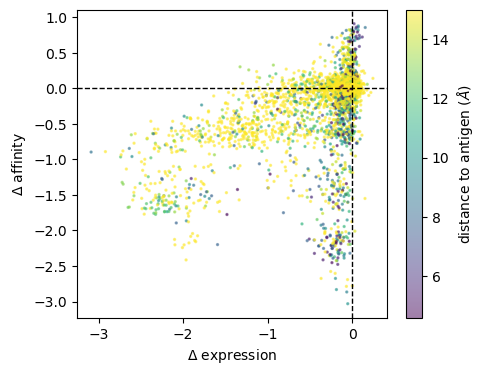

In [49]:
plt.figure(figsize=(5, 4))
plt.scatter(dms_df.delta_expr, y=dms_df.delta_bind_CGG, c=dms_df["distance to antigen"],
            s=2, alpha=0.5,
#             cmap="viridis",
#             vmin=0,
            vmax=15
           )
plt.axvline(0, ls="--", c="k", lw=1)
plt.axhline(0, ls="--", c="k", lw=1)
plt.xlabel(r"$\Delta$ expression")
plt.ylabel(r"$\Delta$ affinity")
plt.colorbar(label=r"distance to antigen ($\AA$)")
# plt.savefig(f"{out_dir}/bind-expr-dist.pdf")
plt.show()

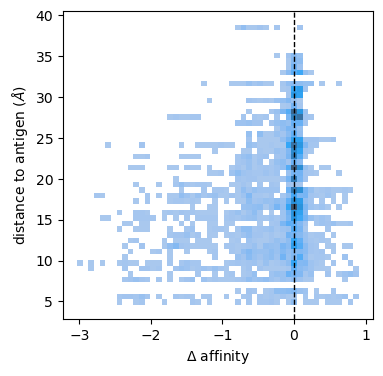

In [50]:
plt.figure(figsize=(4, 4))
sns.histplot(data=dms_df, x="delta_bind_CGG", y="distance to antigen", bins=50)
plt.axvline(0, ls="--", c="k", lw=1)
plt.xlabel(r"$\Delta$ affinity")
plt.ylabel(r"distance to antigen ($\AA$)")
plt.savefig(f"{out_dir}/bind-dist.pdf")
plt.show()

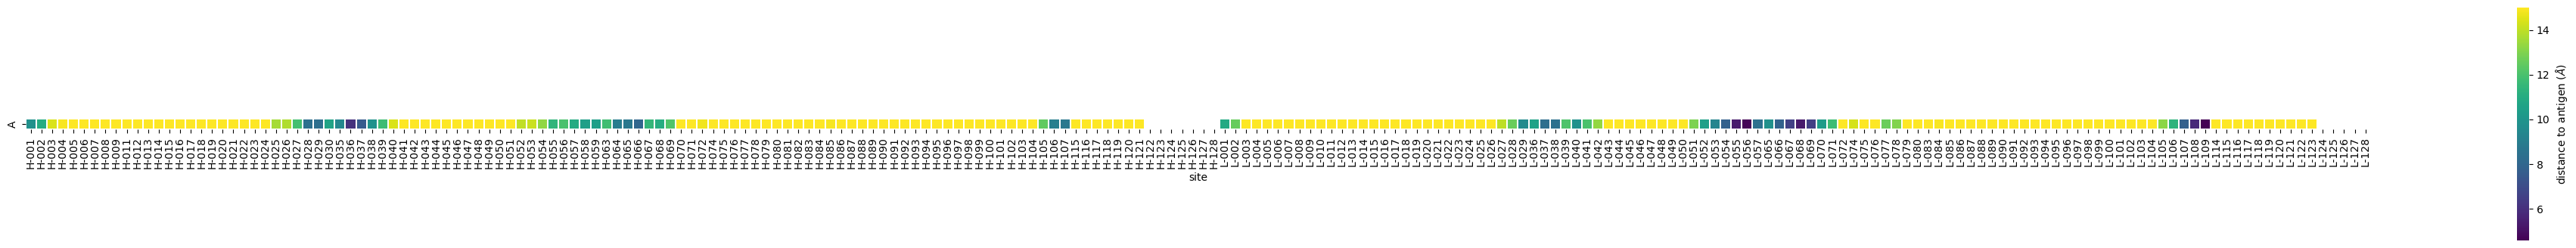

In [51]:
plt.figure(figsize=(50, 4))
sns.heatmap(pd.DataFrame(dms_df.pivot(index="mutant", columns="site", values="distance to antigen").iloc[0, :]).T,
            vmax=15, cmap="viridis",
            cbar_kws=dict(label=r"distance to antigen ($\AA$)"), linewidths=.1, square=True)
plt.savefig(f"{out_dir}/bind-heatmap-distances-row.pdf")
plt.show()

## High-incidence mutations

In [52]:
dms_df[["mutation events", "delta_bind_CGG"]].sort_values("mutation events", ascending=False)[:20]

,mutation events,delta_bind_CGG
mutation,,
S57(H)N,408,0.126849
S64(H)N,288,0.050258
N108(L)K,248,0.859231
S109(L)N,210,0.011334
Q105(L)H,205,0.380333
A105(H)G,182,0.446073
E101(L)D,181,-0.119511
S109(L)R,177,0.794803
Y42(L)F,170,-0.040251


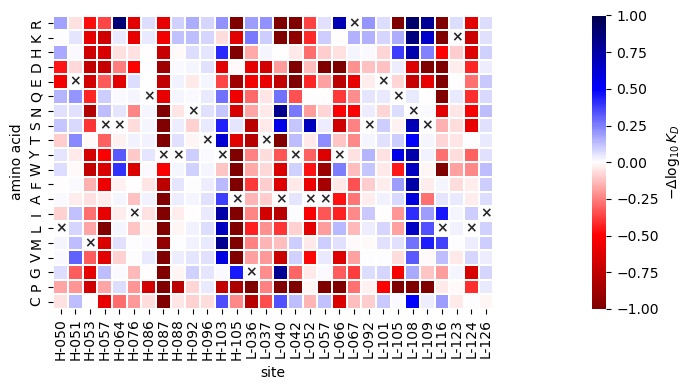

In [53]:
# high_incidence = ["H-057", "H-064", "L-108", "L-109"]
high_incidence = dms_df.loc[dms_df["mutation events"] > dms_df["mutation events"].quantile(0.99)].site.unique()

plt.figure(figsize=(20, 4))
sns.heatmap(bind_df[high_incidence], center=0, vmin=vmin, vmax=vmax, annot=annot[high_incidence], fmt="", annot_kws=dict(fontweight="bold"),
            cmap="seismic_r", cbar_kws=dict(label=r"$-\Delta\log_{10} K_D$"), linewidths=.1, square=True)
plt.xlabel("site")
plt.ylabel("amino acid")
plt.tight_layout()
# plt.savefig(f"{out_dir}/high-incidence.pdf")
plt.show()

## Pairwise epistasis

In [54]:
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import fdrcorrection

In [55]:
mutations =  dms_df.index.unique()

n_mutations = 0
mutation_counts = pd.Series(0, index=mutations)

epi_df = pd.DataFrame(np.zeros((len(mutations), len(mutations))), index=mutations, columns=mutations)

for gc, tree in trees.items():
    print(gc, end="       \r")
    for node in tree.tree.iter_descendants(strategy="preorder"):
        parent_mutations = set(mutation for mutation in node.up.mutations)
        new_mutations = set(mutation for mutation in node.mutations) - parent_mutations
        if any(mutation.endswith("*") for mutation in parent_mutations.union(new_mutations)):
            continue
        for new_mutation in new_mutations:
            n_mutations += 1
            mutation_counts[new_mutation] += 1
        for background_mutation in parent_mutations:
            for new_mutation in new_mutations:
                epi_df.loc[background_mutation, new_mutation] += 1

volcano_dat = []
                
for background_mutation in mutations:
    background_total = epi_df.loc[background_mutation, :].sum()
    if background_total >= 5:
        for new_mutation in mutations:
            if background_mutation[:-1] != new_mutation[:-1] and mutation_counts[new_mutation] >= 5:
                print(background_mutation, end="       \r")
                table = np.zeros((2, 2), dtype=int)
                table[0, 0] = n_mutations - epi_df.loc[background_mutation, new_mutation]
                table[0, 1] = mutation_counts[new_mutation] - epi_df.loc[background_mutation, new_mutation]
                table[1, 0] = background_total - epi_df.loc[background_mutation, new_mutation]
                table[1, 1] = epi_df.loc[background_mutation, new_mutation]
                
                odds_ratio, p_value = fisher_exact(table, alternative="two-sided")
                if p_value < 1e-6:
                    print(background_mutation, new_mutation, odds_ratio, p_value)
                volcano_dat.append([background_mutation, new_mutation, table, odds_ratio, p_value])

volcano_df = pd.DataFrame(volcano_dat, columns=["background mutation", "mutation event", "contingency table", "odds ratio", "p-value"])

_, volcano_df["FDR"] = fdrcorrection(volcano_df["p-value"], method="p")

FDR_tresh = 0.05
volcano_df[f"FDR < {FDR_tresh}"] = volcano_df.FDR < FDR_tresh

epi_muts = volcano_df[volcano_df[f"FDR < {FDR_tresh}"]].sort_values("p-value")
epi_muts

A105(H)G L50(H)F 2.6164677462930883 1.4206287644348632e-08
A105(H)G S57(H)N 2.2895851586457225 3.9412614236341462e-19
A105(H)G S64(H)R 3.228609727174713 1.6827531285315296e-16
A105(H)G N92(H)K 2.6266207662409773 4.790264472538157e-07
A105(H)G T96(H)P 3.6042506756238333 1.3614940643693011e-07
A105(H)G T96(H)S 2.3442036165847027 1.650674988783673e-07
A105(H)G T37(L)S 3.0114653140311254 1.4967224399566064e-08
A105(H)G Q95(L)K 7.7263879672638796 6.30145985138843e-08
A105(H)G E101(L)D 2.013830110973606 5.40578061122119e-07
A105(H)G Q105(L)H 2.687744409148477 4.5533440718182084e-15
A105(H)G N108(L)H 4.244486359209537 2.5197288594942197e-10
A105(H)G N108(L)K 2.270599566128067 2.9739634098030462e-12
A105(H)G N108(L)S 2.9384905563758332 3.502381643757486e-07
A105(H)G S109(L)N 2.1409380947050263 9.790944614304362e-10
A105(H)G S109(L)R 3.150811902423515 4.828241911633369e-16
A105(H)G K123(L)N 3.6525211487088156 3.755086517967499e-13
Q105(L)H Y42(L)F 2.4121117011587665 2.2520006403714046e-07
N108(

,background mutation,mutation event,contingency table,odds ratio,p-value,FDR,FDR < 0.05
137121,A105(H)G,S57(H)N,"[[18583, 232], [8816, 252]]",2.289585,3.941261e-19,1.202983e-13,True
137146,A105(H)G,S64(H)R,"[[18710, 81], [8943, 125]]",3.228610,1.682753e-16,2.568117e-11,True
137573,A105(H)G,S109(L)R,"[[18710, 83], [8943, 125]]",3.150812,4.828242e-16,4.912382e-11,True
137551,A105(H)G,Q105(L)H,"[[18690, 113], [8923, 145]]",2.687744,4.553344e-15,3.474520e-10,True
137596,A105(H)G,K123(L)N,"[[18751, 48], [8984, 84]]",3.652521,3.755087e-13,2.292315e-08,True
137564,A105(H)G,N108(L)K,"[[18679, 144], [8912, 156]]",2.270600,2.973963e-12,1.512895e-07,True
137562,A105(H)G,N108(L)H,"[[18780, 27], [9013, 55]]",4.244486,2.519729e-10,1.098703e-05,True
137572,A105(H)G,S109(L)N,"[[18700, 132], [8933, 135]]",2.140938,9.790945e-10,3.735588e-05,True
137088,A105(H)G,L50(H)F,"[[18756, 63], [8989, 79]]",2.616468,1.420629e-08,4.568416e-04,True
137380,A105(H)G,T37(L)S,"[[18770, 45], [9003, 65]]",3.011465,1.496722e-08,4.568416e-04,True


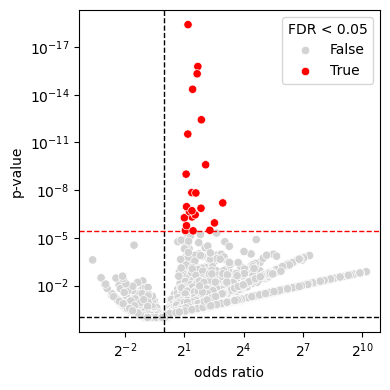

In [56]:
plt.figure(figsize=(4, 4))
ax = sns.scatterplot(data=volcano_df, x="odds ratio", y="p-value", hue=f"FDR < {FDR_tresh}", palette=["lightgrey", "red"])
ax.invert_yaxis()
plt.axvline(1, ls="--", c="k", lw=1)
plt.axhline(1, ls="--", c="k", lw=1)
plt.axhline(volcano_df.loc[volcano_df[f"FDR < {FDR_tresh}"], "p-value"].max(), ls="--", c="red", lw=1)
plt.xscale("log", base=2)
plt.yscale("log")
plt.tight_layout()
# plt.savefig(f"{out_dir}/epistasis.volcano.pdf")
plt.show()

In [57]:
epi_muts.to_csv(f"{out_dir}/epistatic-pairs.csv", index=False)

Where are the above mutations in our scatters?

In [58]:
background_indicator = dms_df.index.isin(epi_muts["background mutation"])
enabled_indicator = dms_df.index.isin(epi_muts["mutation event"])
indicator = ["other"] * len(dms_df)
for i in range(len(indicator)):
    if background_indicator[i]:
        indicator[i] = "epistatic background mutation"
    elif enabled_indicator[i]:
        indicator[i] = "epistatically enabled mutation"
indicator = pd.Series(indicator, index=dms_df.index, name="mutation type")

# indicator = dms_df.index == "A40(L)G" #"A40(L)G"

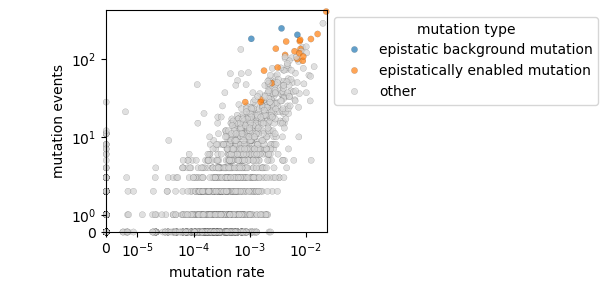

In [59]:
plt.figure(figsize=(6, 3))

ax = sns.scatterplot(x=dms_df["mutation rate"], y=dms_df["mutation events"], hue=indicator, s=20, alpha=0.7,
                     hue_order=("epistatic background mutation", "epistatically enabled mutation", "other"),
                     palette=("C0", "C1", "lightgrey"),
                     clip_on=False, edgecolors="k", linewidths=0.1)
# plt.xlabel("mutation rate")
plt.ylabel("mutation events")
linthresh_x = 1e-5
linthresh_y = 1.0
plt.xscale("symlog", linthresh=linthresh_x, linscale=.5)
plt.yscale("symlog", linthresh=linthresh_y, linscale=.2)
plt.xlim(0, None)
plt.ylim(0, None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
# plt.savefig(f"{out_dir}/eventsVsrate-epistatic.pdf")
plt.show()

LBI of nodes with the above mutations

,LBI,LBR,mutation pair on tree node
0,3.668779,0.000000,enabling mutation only
1,3.668779,0.000000,enabling mutation only
2,19.295081,1.912296,enabling and enabled mutation
3,19.957673,2.060205,enabling and enabled mutation
4,3.943823,0.000000,enabling mutation only
...,...,...,...
891,4.589538,0.000000,enabling mutation only
892,2.289046,0.000000,enabling mutation only
893,16.301352,4.952217,enabling mutation only
894,6.396509,0.000000,enabling mutation only


/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/wsdewitt/miniconda3/envs/replay/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


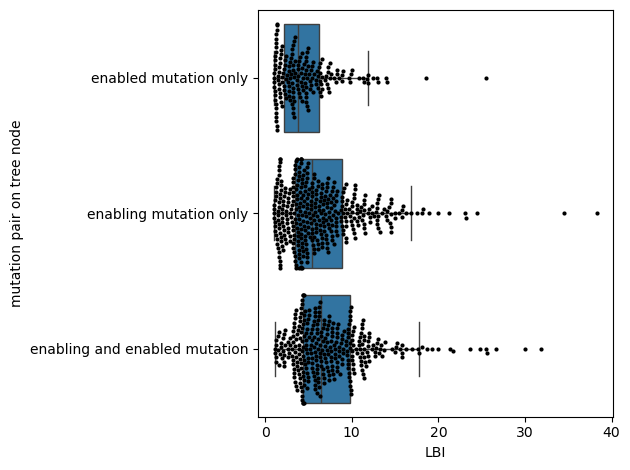

In [60]:
lbi_dat = []
pairs = set((x, y) for x, y in volcano_df.loc[volcano_df[f"FDR < {FDR_tresh}"], ["background mutation", "mutation event"]].values)
for gc, tree in trees.items():
    for node in tree.tree.traverse():
        mutations = set(node.mutations)
        # if node.get_distance(tree.tree) <= 4:
        if len(mutations) == 2:
            if any(set(pair) <= mutations for pair in pairs):            
                lbi_dat.append([node.LBI, node.LBR, "enabling and enabled mutation"])
            elif any(pair[0] in mutations for pair in pairs):
                lbi_dat.append([node.LBI, node.LBR, "enabling mutation only"])
            elif any(pair[1] in mutations for pair in pairs):
                lbi_dat.append([node.LBI, node.LBR, "enabled mutation only"])
            # else:
            #     lbi_dat.append([node.LBI, node.LBR, "none"])

lbi_df = pd.DataFrame(lbi_dat, columns=("LBI", "LBR", "mutation pair on tree node"))

display(lbi_df)

# plt.figure(figsize=(10, 3))
sns.boxplot(data=lbi_df, y="mutation pair on tree node", x="LBI", order=("enabled mutation only", "enabling mutation only", "enabling and enabled mutation"), fliersize=0)
sns.swarmplot(data=lbi_df, y="mutation pair on tree node", x="LBI", order=("enabled mutation only", "enabling mutation only", "enabling and enabled mutation"), color="k", size=3)
plt.tight_layout()
# plt.savefig(f"{out_dir}/epistasis.LBI.pdf")
plt.show()


In [61]:
from scipy.stats import kruskal, mannwhitneyu

kruskal(lbi_df[lbi_df["mutation pair on tree node"] == "enabled mutation only"].LBI,
        lbi_df[lbi_df["mutation pair on tree node"] == "enabling mutation only"].LBI,
        lbi_df[lbi_df["mutation pair on tree node"] == "enabling and enabled mutation"].LBI)

KruskalResult(statistic=70.83860869764186, pvalue=4.14563983218611e-16)

In [62]:
mannwhitneyu(lbi_df[lbi_df["mutation pair on tree node"] == "enabled mutation only"].LBI,
             lbi_df[lbi_df["mutation pair on tree node"] == "enabling mutation only"].LBI)

MannwhitneyuResult(statistic=24404.0, pvalue=3.9232055496697974e-08)

In [63]:
mannwhitneyu(lbi_df[lbi_df["mutation pair on tree node"] == "enabled mutation only"].LBI,
             lbi_df[lbi_df["mutation pair on tree node"] == "enabling and enabled mutation"].LBI)

MannwhitneyuResult(statistic=16247.0, pvalue=3.779844479529094e-17)

In [64]:
mannwhitneyu(lbi_df[lbi_df["mutation pair on tree node"] == "enabling mutation only"].LBI,
             lbi_df[lbi_df["mutation pair on tree node"] == "enabling and enabled mutation"].LBI)

MannwhitneyuResult(statistic=53654.5, pvalue=0.00016355920209947775)

### Redoing above using Yun's approach of coincidence of mutations on nodes

In [65]:
n_mutations, mutation_counts.sum()

(18835, 18835)

In [66]:
mutations =  dms_df.index.unique()

n_mutations = 0
mutation_counts = pd.Series(0, index=mutations)

epi_df = pd.DataFrame(np.zeros((len(mutations), len(mutations))), index=mutations, columns=mutations)

for gc, tree in trees.items():
    print(gc, end="       \r")
    for node in tree.tree.iter_descendants(strategy="preorder"):
        if any(mutation.endswith("*") for mutation in node.mutations):
            continue
        for i, mutation1 in enumerate(node.mutations):
            n_mutations += 1
            mutation_counts[mutation1] += 1
            for mutation2 in node.mutations[i + 1:]:
                epi_df.loc[mutation1, mutation2] += 1

volcano_dat = []
                
for i, mutation1 in enumerate(mutations):
    mutation1_total = mutation_counts[mutation1]
    if mutation1_total >= 50:
        for mutation2 in mutations[i + 1:]:
            if mutation1[:-1] != mutation2[:-1] and mutation_counts[mutation2] >= 5:
                print(mutation1, end="       \r")
                table = np.zeros((2, 2), dtype=int)
                table[0, 0] = n_mutations - epi_df.loc[mutation1, mutation2]
                table[0, 1] = mutation_counts[mutation2] - epi_df.loc[mutation1, mutation2]
                table[1, 0] = mutation1_total - epi_df.loc[mutation1, mutation2]
                table[1, 1] = epi_df.loc[mutation1, mutation2]
                
                odds_ratio, p_value = fisher_exact(table, alternative="two-sided")
                row = [mutation1, mutation2, table, odds_ratio, p_value]
                # if p_value < 1e-6:
                #     print(row)
                volcano_dat.append(row)

volcano_df = pd.DataFrame(volcano_dat, columns=["mutation 1", "mutation 2", "contingency table", "odds ratio", "p-value"])

_, volcano_df["FDR"] = fdrcorrection(volcano_df["p-value"], method="p")

FDR_tresh = 0.05
volcano_df[f"FDR < {FDR_tresh}"] = volcano_df.FDR < FDR_tresh

volcano_df[volcano_df[f"FDR < {FDR_tresh}"]].sort_values("p-value")

,mutation 1,mutation 2,contingency table,odds ratio,p-value,FDR,FDR < 0.05
57940,Q105(L)H,L116(L)I,"[[52619, 490], [1242, 540]]",46.689441,0.000000,0.000000,True
43463,A105(H)G,S109(L)R,"[[52565, 247], [5203, 594]]",24.295863,0.000000,0.000000,True
16536,S57(H)N,A105(H)G,"[[52213, 4851], [608, 946]]",16.746919,0.000000,0.000000,True
43438,A105(H)G,Q105(L)H,"[[52292, 915], [4930, 867]]",10.050469,0.000000,0.000000,True
43453,A105(H)G,N108(L)K,"[[51641, 841], [4279, 1518]]",21.783524,0.000000,0.000000,True
...,...,...,...,...,...,...,...
27928,S74(H)G,M11(L)L,"[[53156, 103], [161, 3]]",9.616354,0.004348,0.049602,True
16388,S57(H)N,Y67(H)D,"[[53155, 20], [1550, 4]]",6.858710,0.004370,0.049846,True
37365,N92(H)K,N108(L)F,"[[53157, 13], [354, 2]]",23.101695,0.004374,0.049883,True
30731,K84(H)R,Y88(H)F,"[[53156, 193], [86, 3]]",9.607664,0.004377,0.049913,True
